In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
data = pd.read_csv('my_data.csv', parse_dates=['time'], index_col='time')

In [ ]:
data.head()

,open,close,spread,year,month,day,weekday
time,,,,,,,
2010-07-23 03:45:00,18.900000,19.240000,0.340000,2010,7,23,3
2010-07-26 03:45:00,19.240000,19.969999,0.729999,2010,7,26,6
2010-07-27 03:45:00,19.969999,19.219999,-0.750000,2010,7,27,7
2010-07-28 03:45:00,19.219999,19.520000,0.300001,2010,7,28,1
2010-07-29 03:45:00,19.520000,18.330000,-1.190000,2010,7,29,2


In [ ]:
data = data["close"]

Text(0.5, 1.0, 'closing price')

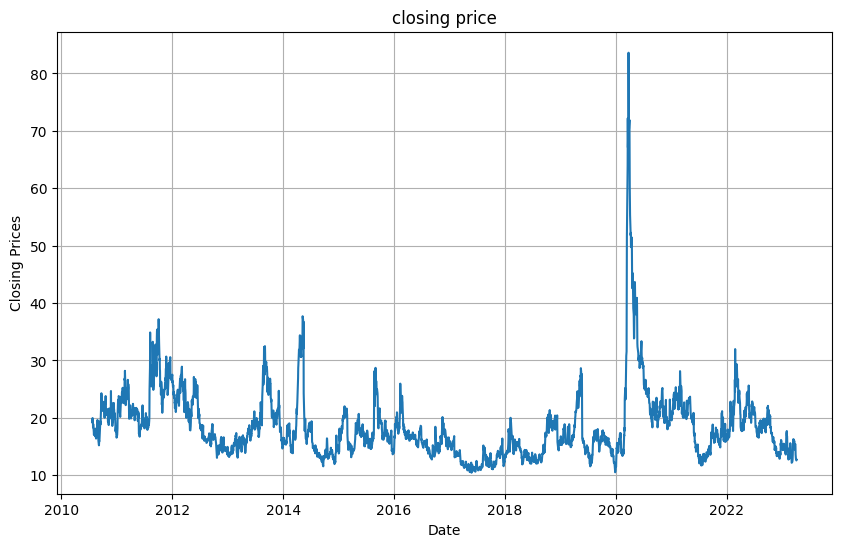

In [ ]:
df_close = data['close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('closing price')

In [ ]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

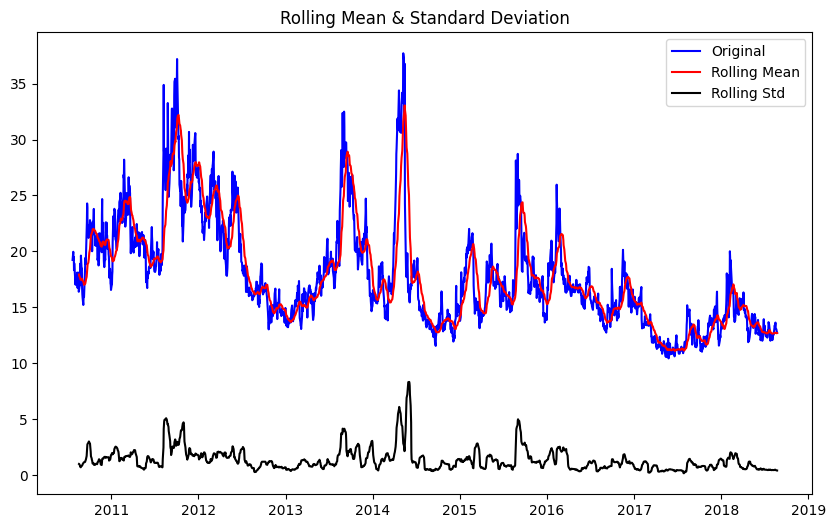

Results of Dickey-Fuller Test:
Test Statistic                   -3.985050
p-value                           0.001491
#Lags Used                       13.000000
Number of Observations Used    1986.000000
Critical Value (1%)              -3.433647
Critical Value (5%)              -2.862996
Critical Value (10%)             -2.567545
dtype: float64


In [ ]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

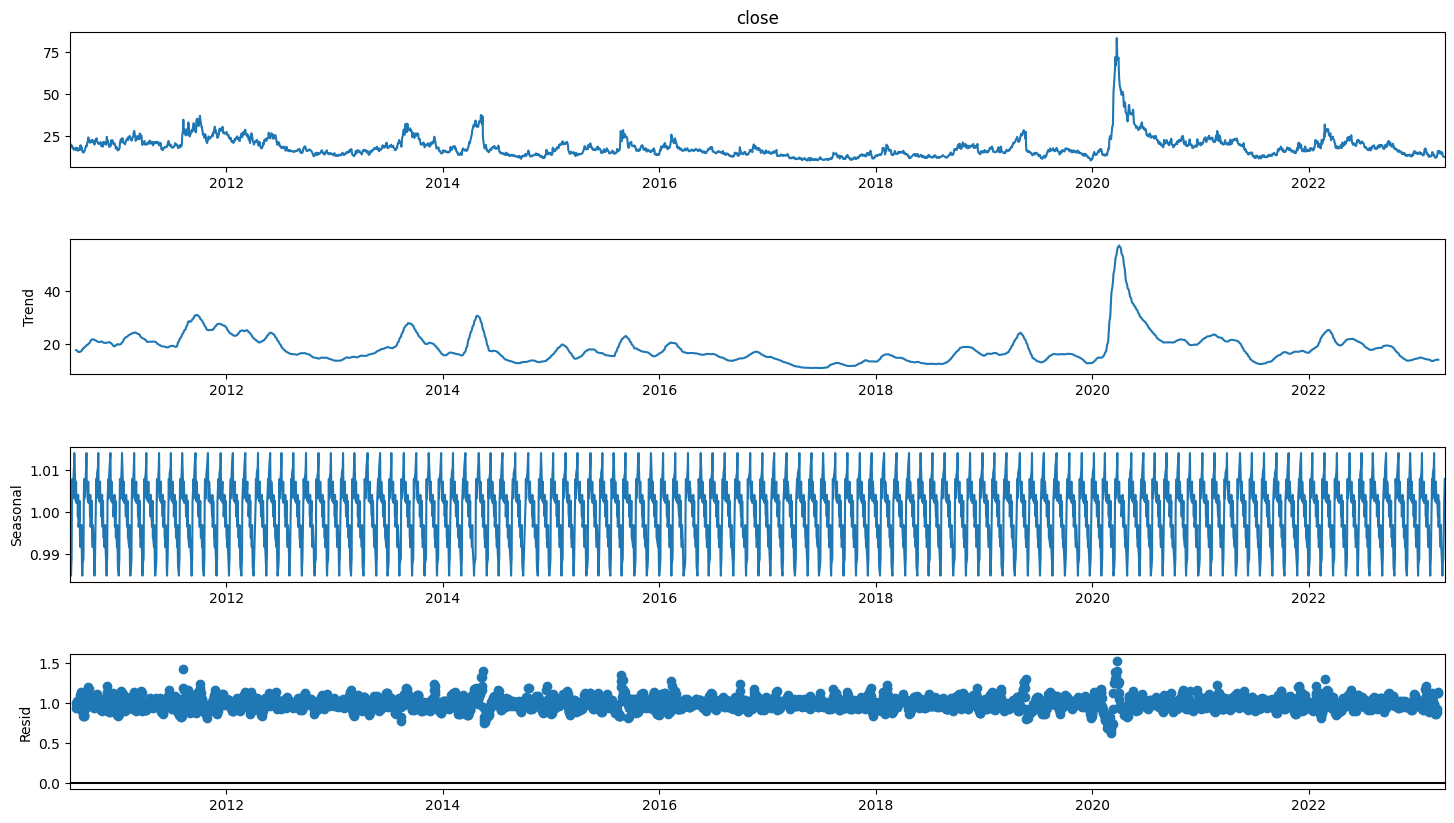

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

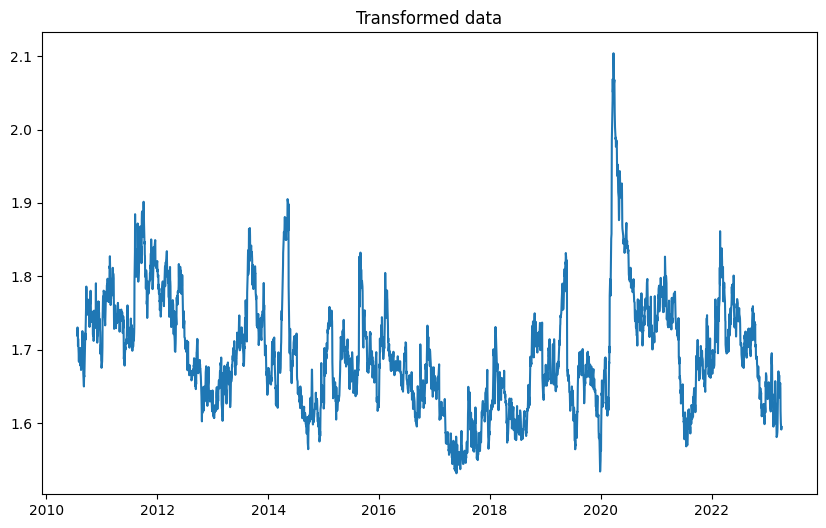

In [ ]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

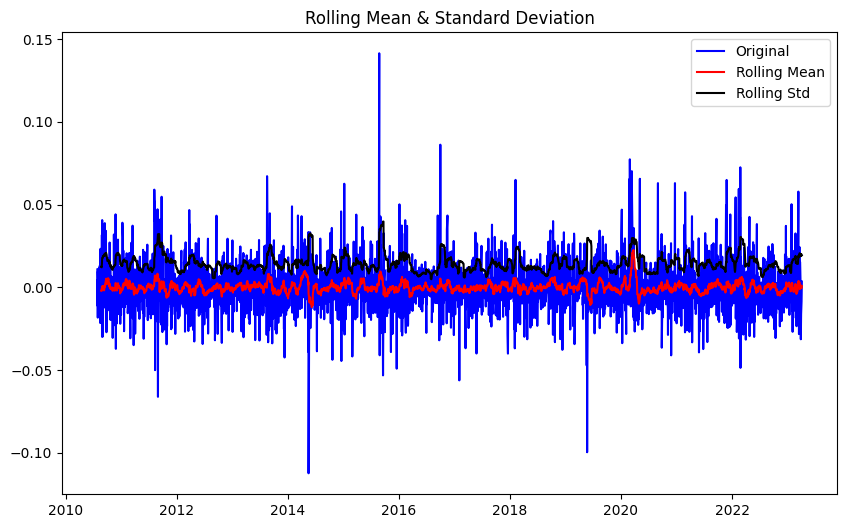

Results of Dickey-Fuller Test:
Test Statistic                -1.691871e+01
p-value                        9.978230e-30
#Lags Used                     1.000000e+01
Number of Observations Used    3.130000e+03
Critical Value (1%)           -3.432441e+00
Critical Value (5%)           -2.862464e+00
Critical Value (10%)          -2.567262e+00
dtype: float64


In [ ]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [ ]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [ ]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [ ]:
test_days = 365 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

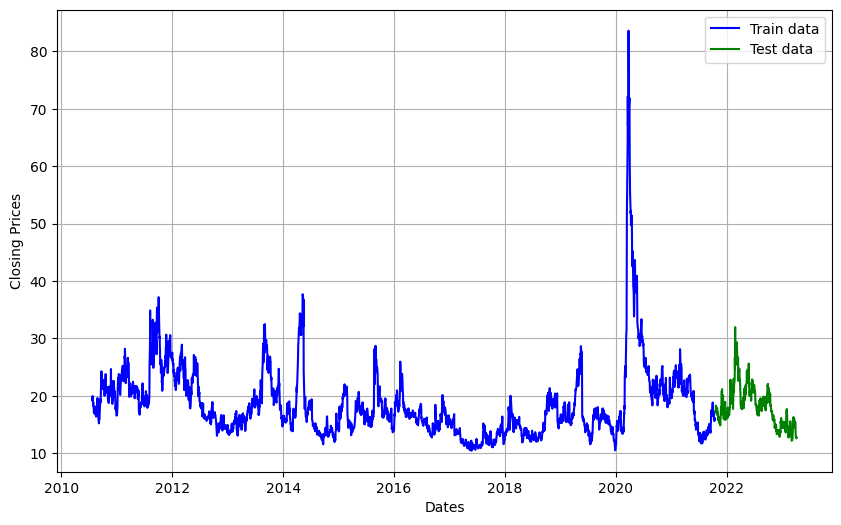

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [ ]:
def vanilla_LSTM():
    model = Sequential()    
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [ ]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

Epoch 1/15
85/85 [==============================] - 7s 29ms/step - loss: 2.3265e-04 - mean_absolute_error: 0.0109
Epoch 2/15
85/85 [==============================] - 2s 25ms/step - loss: 2.2879e-04 - mean_absolute_error: 0.0108
Epoch 3/15
85/85 [==============================] - 2s 28ms/step - loss: 2.2780e-04 - mean_absolute_error: 0.0107
Epoch 4/15
85/85 [==============================] - 3s 40ms/step - loss: 2.2594e-04 - mean_absolute_error: 0.0107
Epoch 5/15
85/85 [==============================] - 3s 40ms/step - loss: 2.2397e-04 - mean_absolute_error: 0.0107
Epoch 6/15
85/85 [==============================] - 3s 34ms/step - loss: 2.2724e-04 - mean_absolute_error: 0.0108
Epoch 7/15
85/85 [==============================] - 3s 32ms/step - loss: 2.2451e-04 - mean_absolute_error: 0.0107
Epoch 8/15
85/85 [==============================] - 7s 86ms/step - loss: 2.2578e-04 - mean_absolute_error: 0.0107
Epoch 9/15
85/85 [==============================] - 5s 59ms/step - loss: 2.2510e-04 - me

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 2s 9ms/step - loss: 2.5040e-04 - mean_absolute_error: 0.0115
Test MSE: 0.00025040307082235813
Test MAE: 0.011527830734848976


12/12 [==============================] - 0s 9ms/step


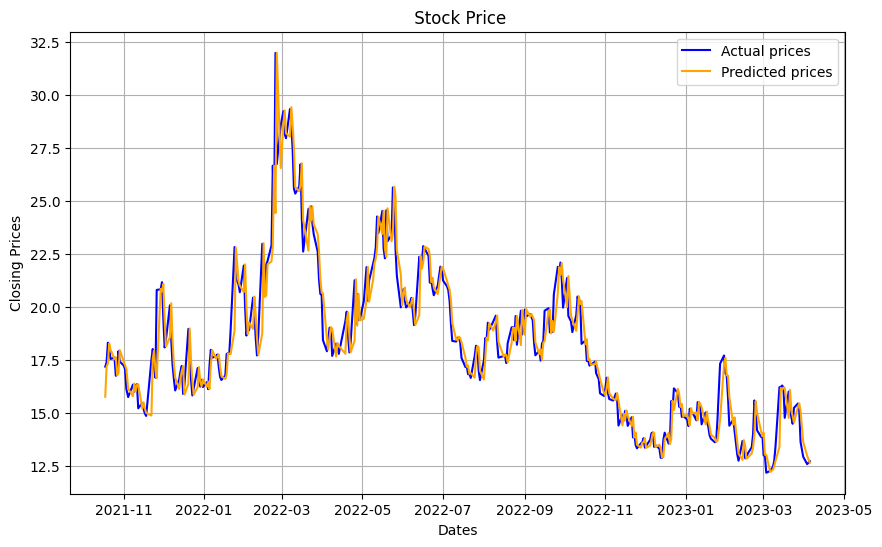

In [ ]:
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(' Stock Price')

plt.legend()

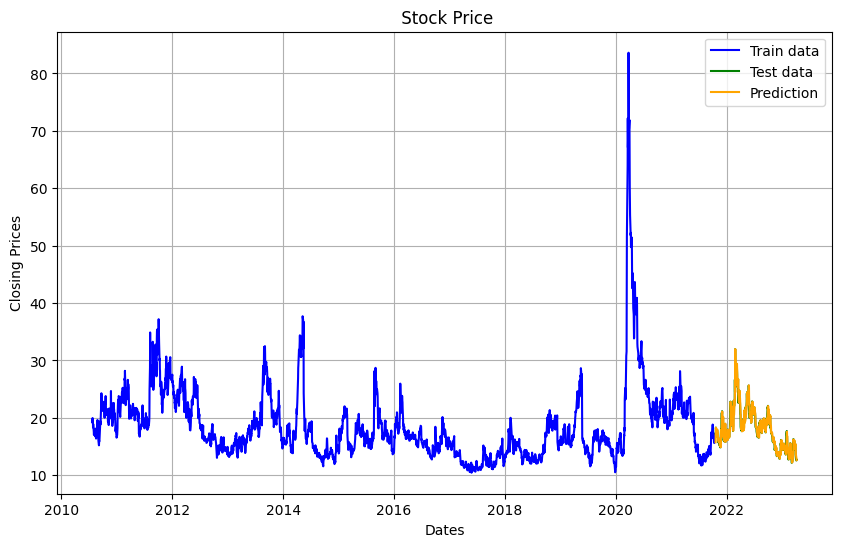

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title(' Stock Price')
plt.legend()

In [ ]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    return X, y

In [ ]:
n_steps_out = 10

# choose the number of days on which to base our predictions 
nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

In [ ]:
test_days = 365 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [ ]:
def vanilla_multistep_LSTM():
    model = Sequential()    
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [ ]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, 
          y_train, 
          epochs=15, 
          batch_size = 32)

Epoch 1/15
85/85 [==============================] - 5s 27ms/step - loss: 2.2880e-04 - mean_absolute_error: 0.0108
Epoch 2/15
85/85 [==============================] - 2s 26ms/step - loss: 2.2623e-04 - mean_absolute_error: 0.0107
Epoch 3/15
85/85 [==============================] - 4s 44ms/step - loss: 2.2701e-04 - mean_absolute_error: 0.0108
Epoch 4/15
85/85 [==============================] - 4s 44ms/step - loss: 2.2666e-04 - mean_absolute_error: 0.0107
Epoch 5/15
85/85 [==============================] - 3s 29ms/step - loss: 2.2550e-04 - mean_absolute_error: 0.0107
Epoch 6/15
85/85 [==============================] - 2s 27ms/step - loss: 2.2615e-04 - mean_absolute_error: 0.0107
Epoch 7/15
85/85 [==============================] - 4s 43ms/step - loss: 2.2579e-04 - mean_absolute_error: 0.0107
Epoch 8/15
85/85 [==============================] - 2s 28ms/step - loss: 2.2595e-04 - mean_absolute_error: 0.0107
Epoch 9/15
85/85 [==============================] - 2s 28ms/step - loss: 2.2511e-04 - me

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 [==============================] - 1s 12ms/step - loss: 2.4950e-04 - mean_absolute_error: 0.0115
Test MSE: 0.00024949954240582883
Test MAE: 0.011502481065690517


12/12 [==============================] - 1s 12ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

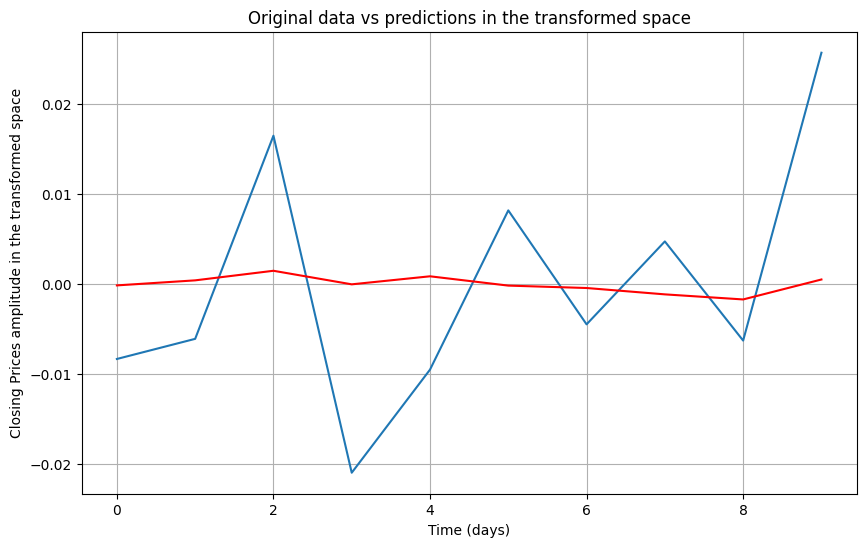

In [ ]:
y_pred = model.predict(X_test)

# the_day is the day from which we will study the n_steps_out-th dayS of prediction into 
# the future. Note: The first day start at index 0
the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [ ]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

time
2021-10-18 03:45:00    1.695977
2021-10-19 03:45:00    1.696398
2021-10-20 03:45:00    1.697884
2021-10-21 03:45:00    1.697863
2021-10-22 03:45:00    1.698734
2021-10-25 03:45:00    1.698572
2021-10-26 03:45:00    1.698143
2021-10-27 03:45:00    1.697007
2021-10-28 03:45:00    1.695306
2021-10-29 03:45:00    1.695824
dtype: float64


In [ ]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

time
2021-10-18 03:45:00    17.749144
2021-10-19 03:45:00    17.774516
2021-10-20 03:45:00    17.864383
2021-10-21 03:45:00    17.863104
2021-10-22 03:45:00    17.916065
2021-10-25 03:45:00    17.906221
2021-10-26 03:45:00    17.880116
2021-10-27 03:45:00    17.811293
2021-10-28 03:45:00    17.708842
2021-10-29 03:45:00    17.739924
dtype: float64


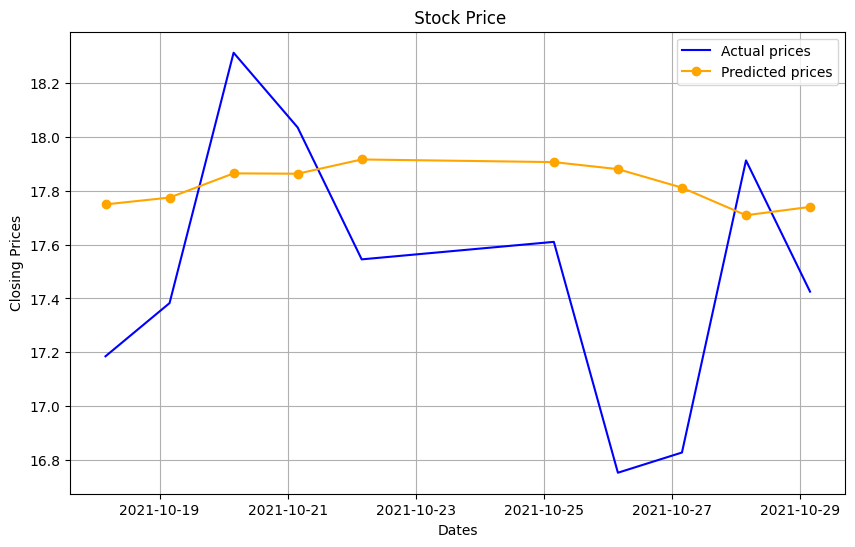

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(' Stock Price')

plt.legend()

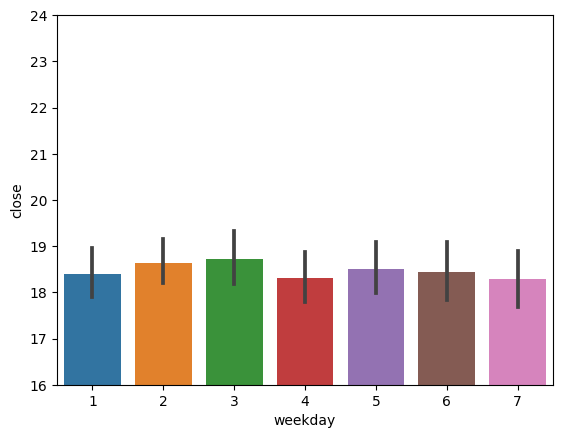

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
barplot = sns.barplot(x='weekday',y='close',data=data,errorbar=('ci', 95)) 
barplot.set_ylim((16,24))
plt.show()

The line in each bar in the plot is the error bar. Error bars indicate the variability of the data and show the range of values within which the true population mean is likely to lie.

In this specific bar plot, the error bars show the 95% confidence interval around the mean value of the VKOSPI close price for each day of the week. This means that there is a 95% chance that the true population mean lies within the range indicated by the error bars.



If the error bars are longer, it means that there is more variability in the data, and if they are shorter, it means that there is less variability. The length of the error bars can help in assessing the significance of any differences between the means of the different groups.

In [ ]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro
from scipy.stats import probplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
!pip install arch


<Axes: xlabel='time'>

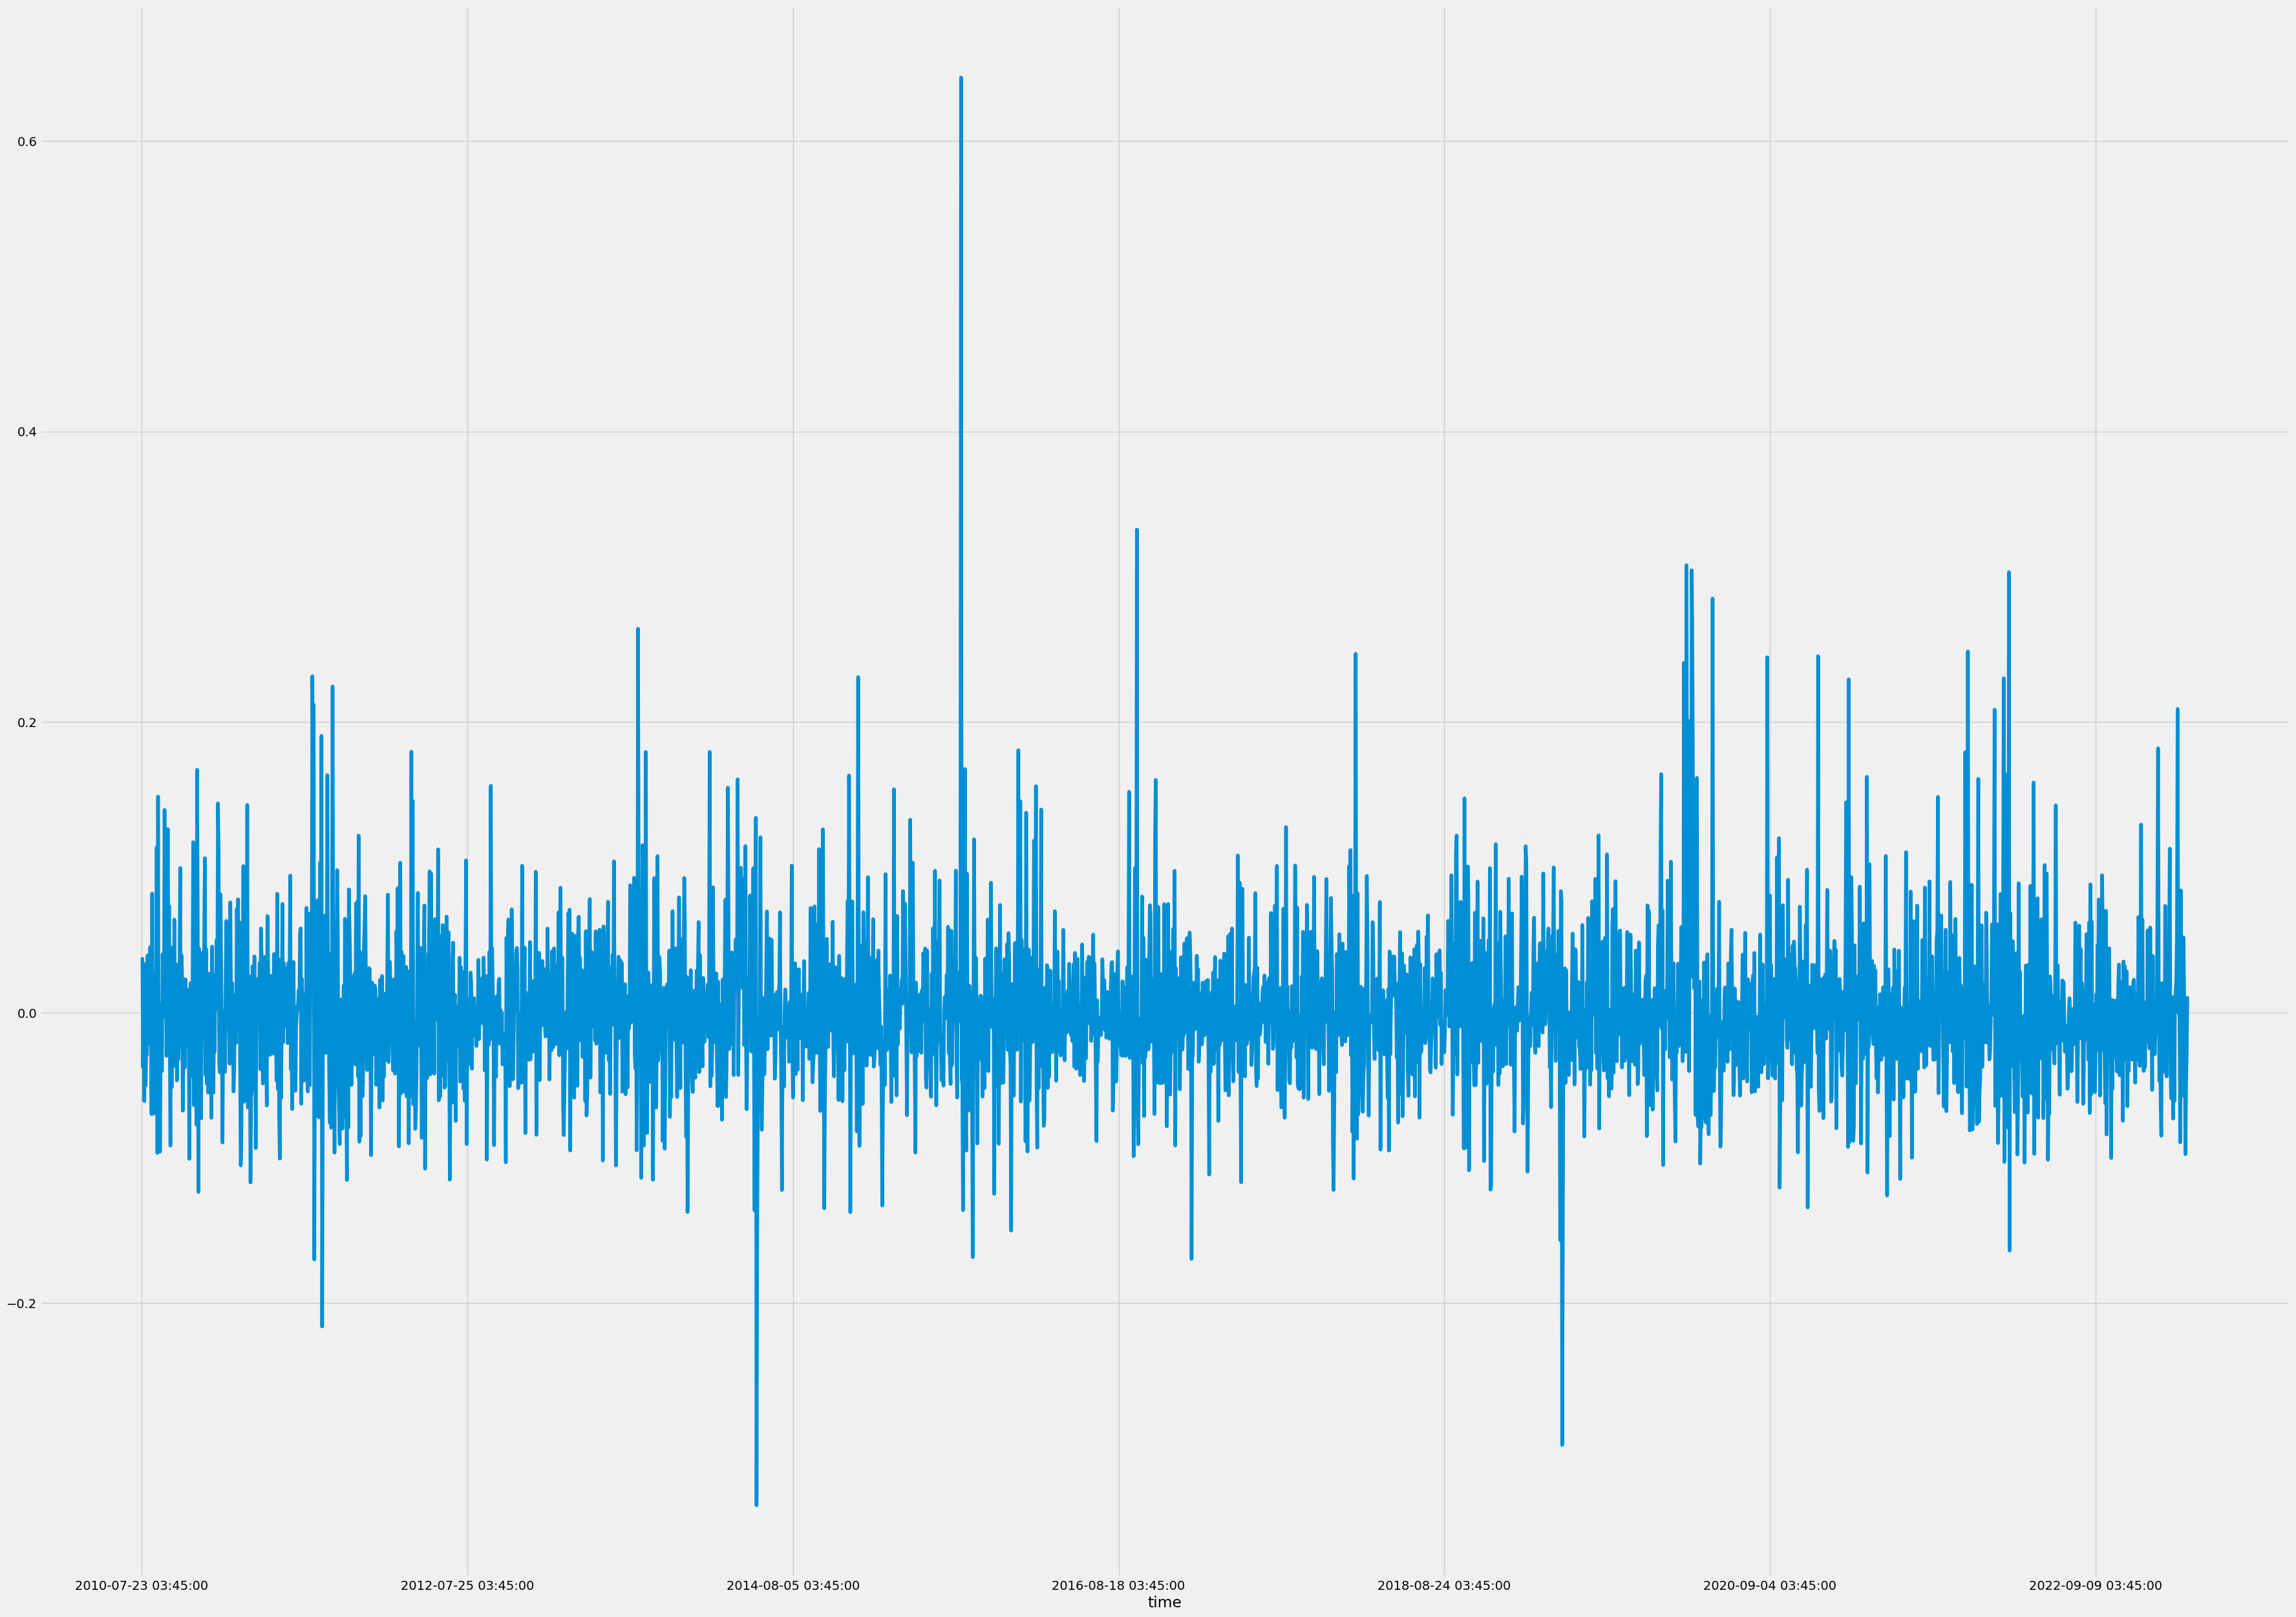

In [ ]:
df = pd.read_csv('my_data.csv')
df.set_index("time", drop=False, inplace=True)
plt.rcParams.update({'figure.figsize': (40,30)})    
df.close.pct_change().plot()

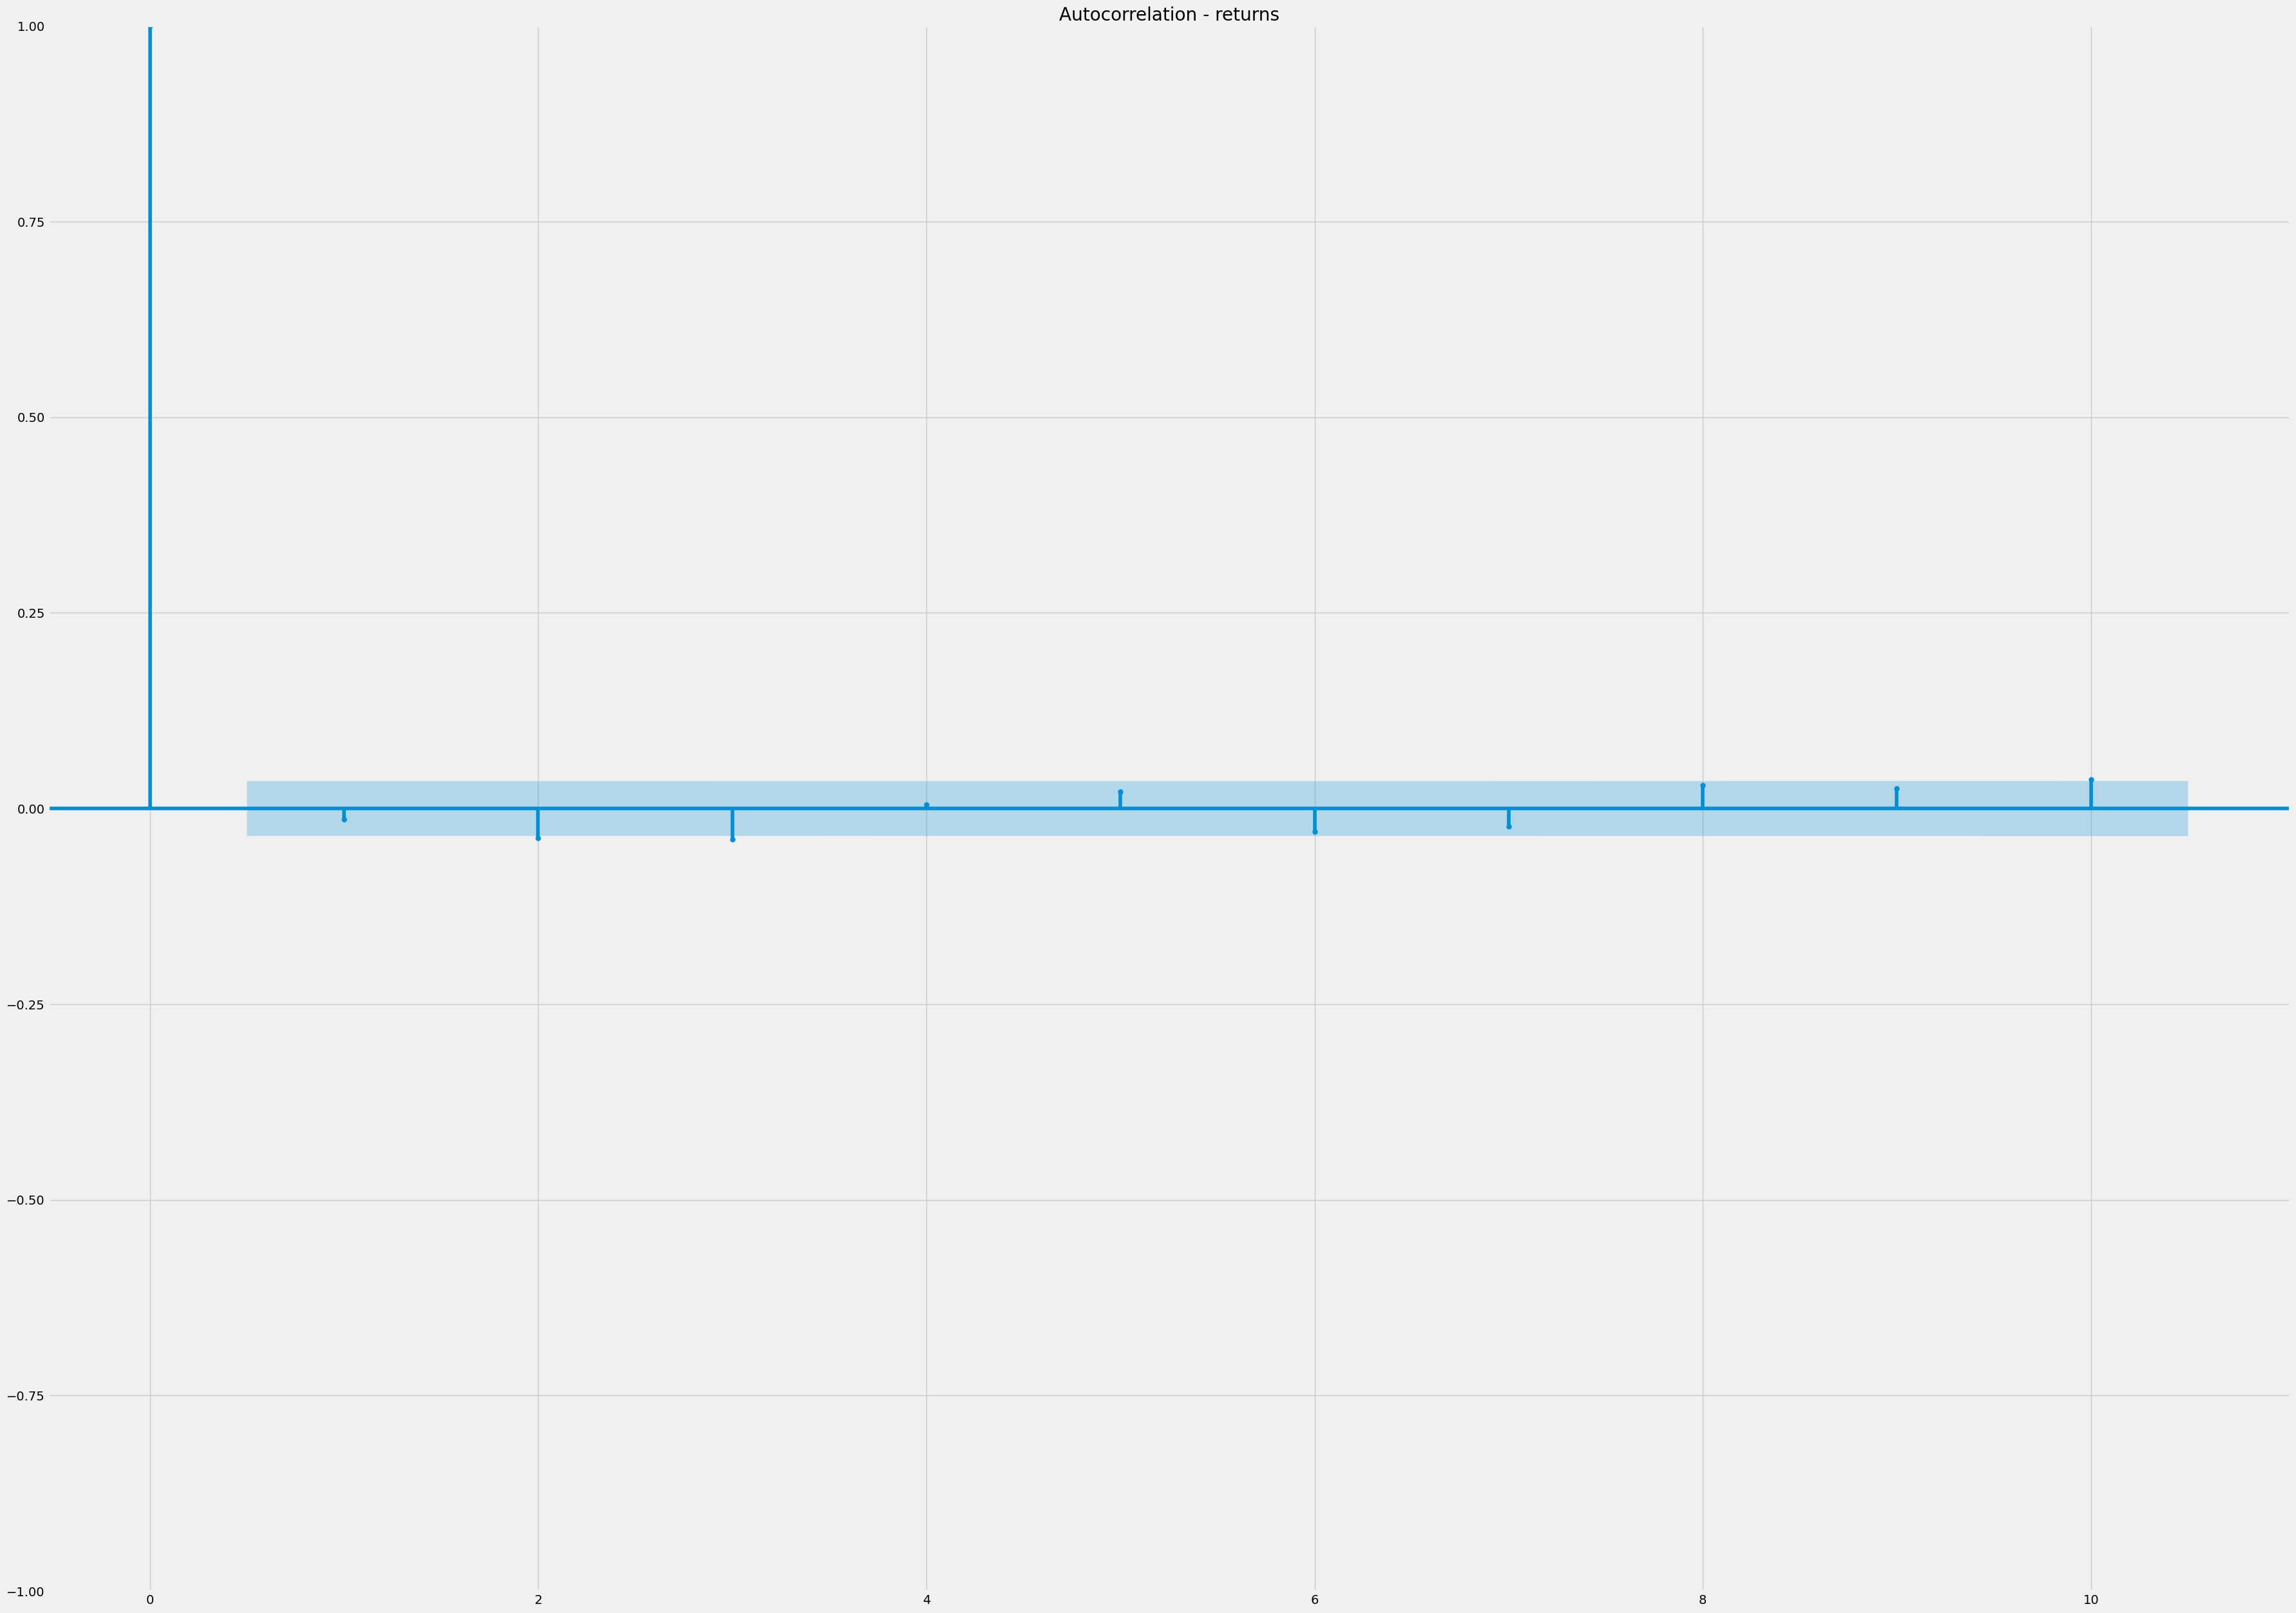

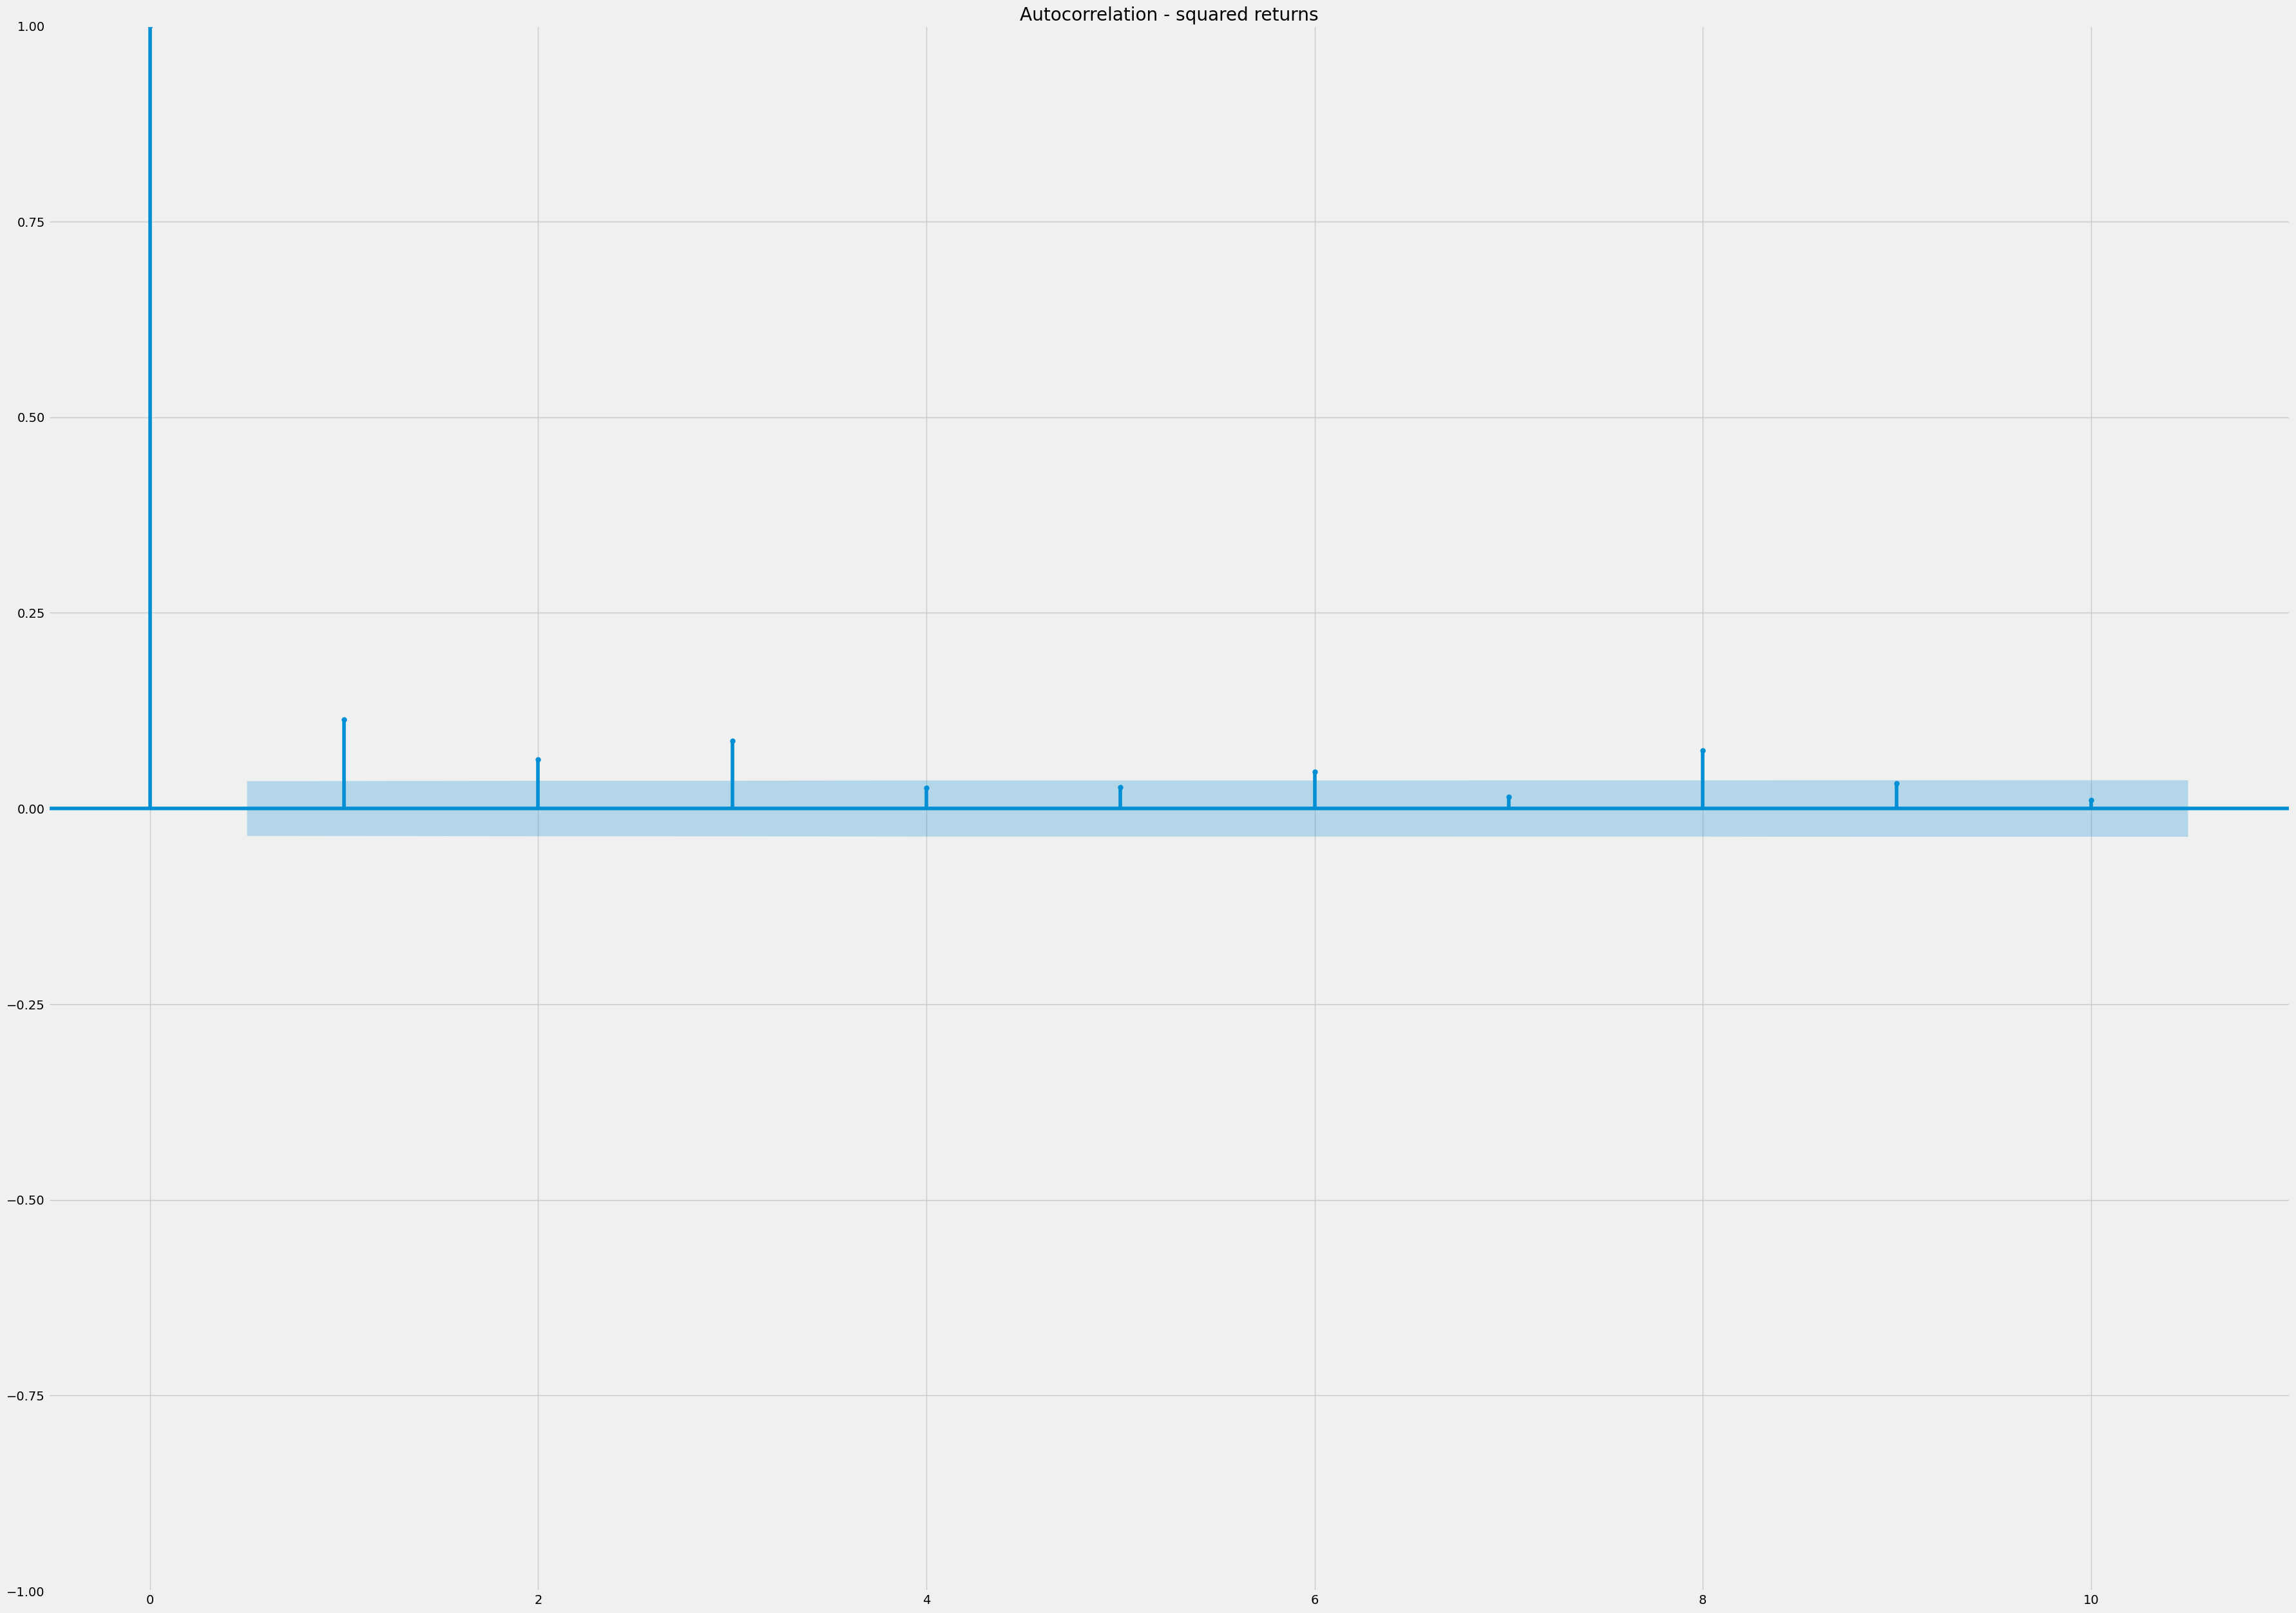

In [ ]:
dfl = np.log1p(df.close).diff().dropna()
plot_acf(dfl, lags = 10, title='Autocorrelation - returns'); print()
plot_acf(dfl**2, lags = 10, title='Autocorrelation - squared returns'); print()

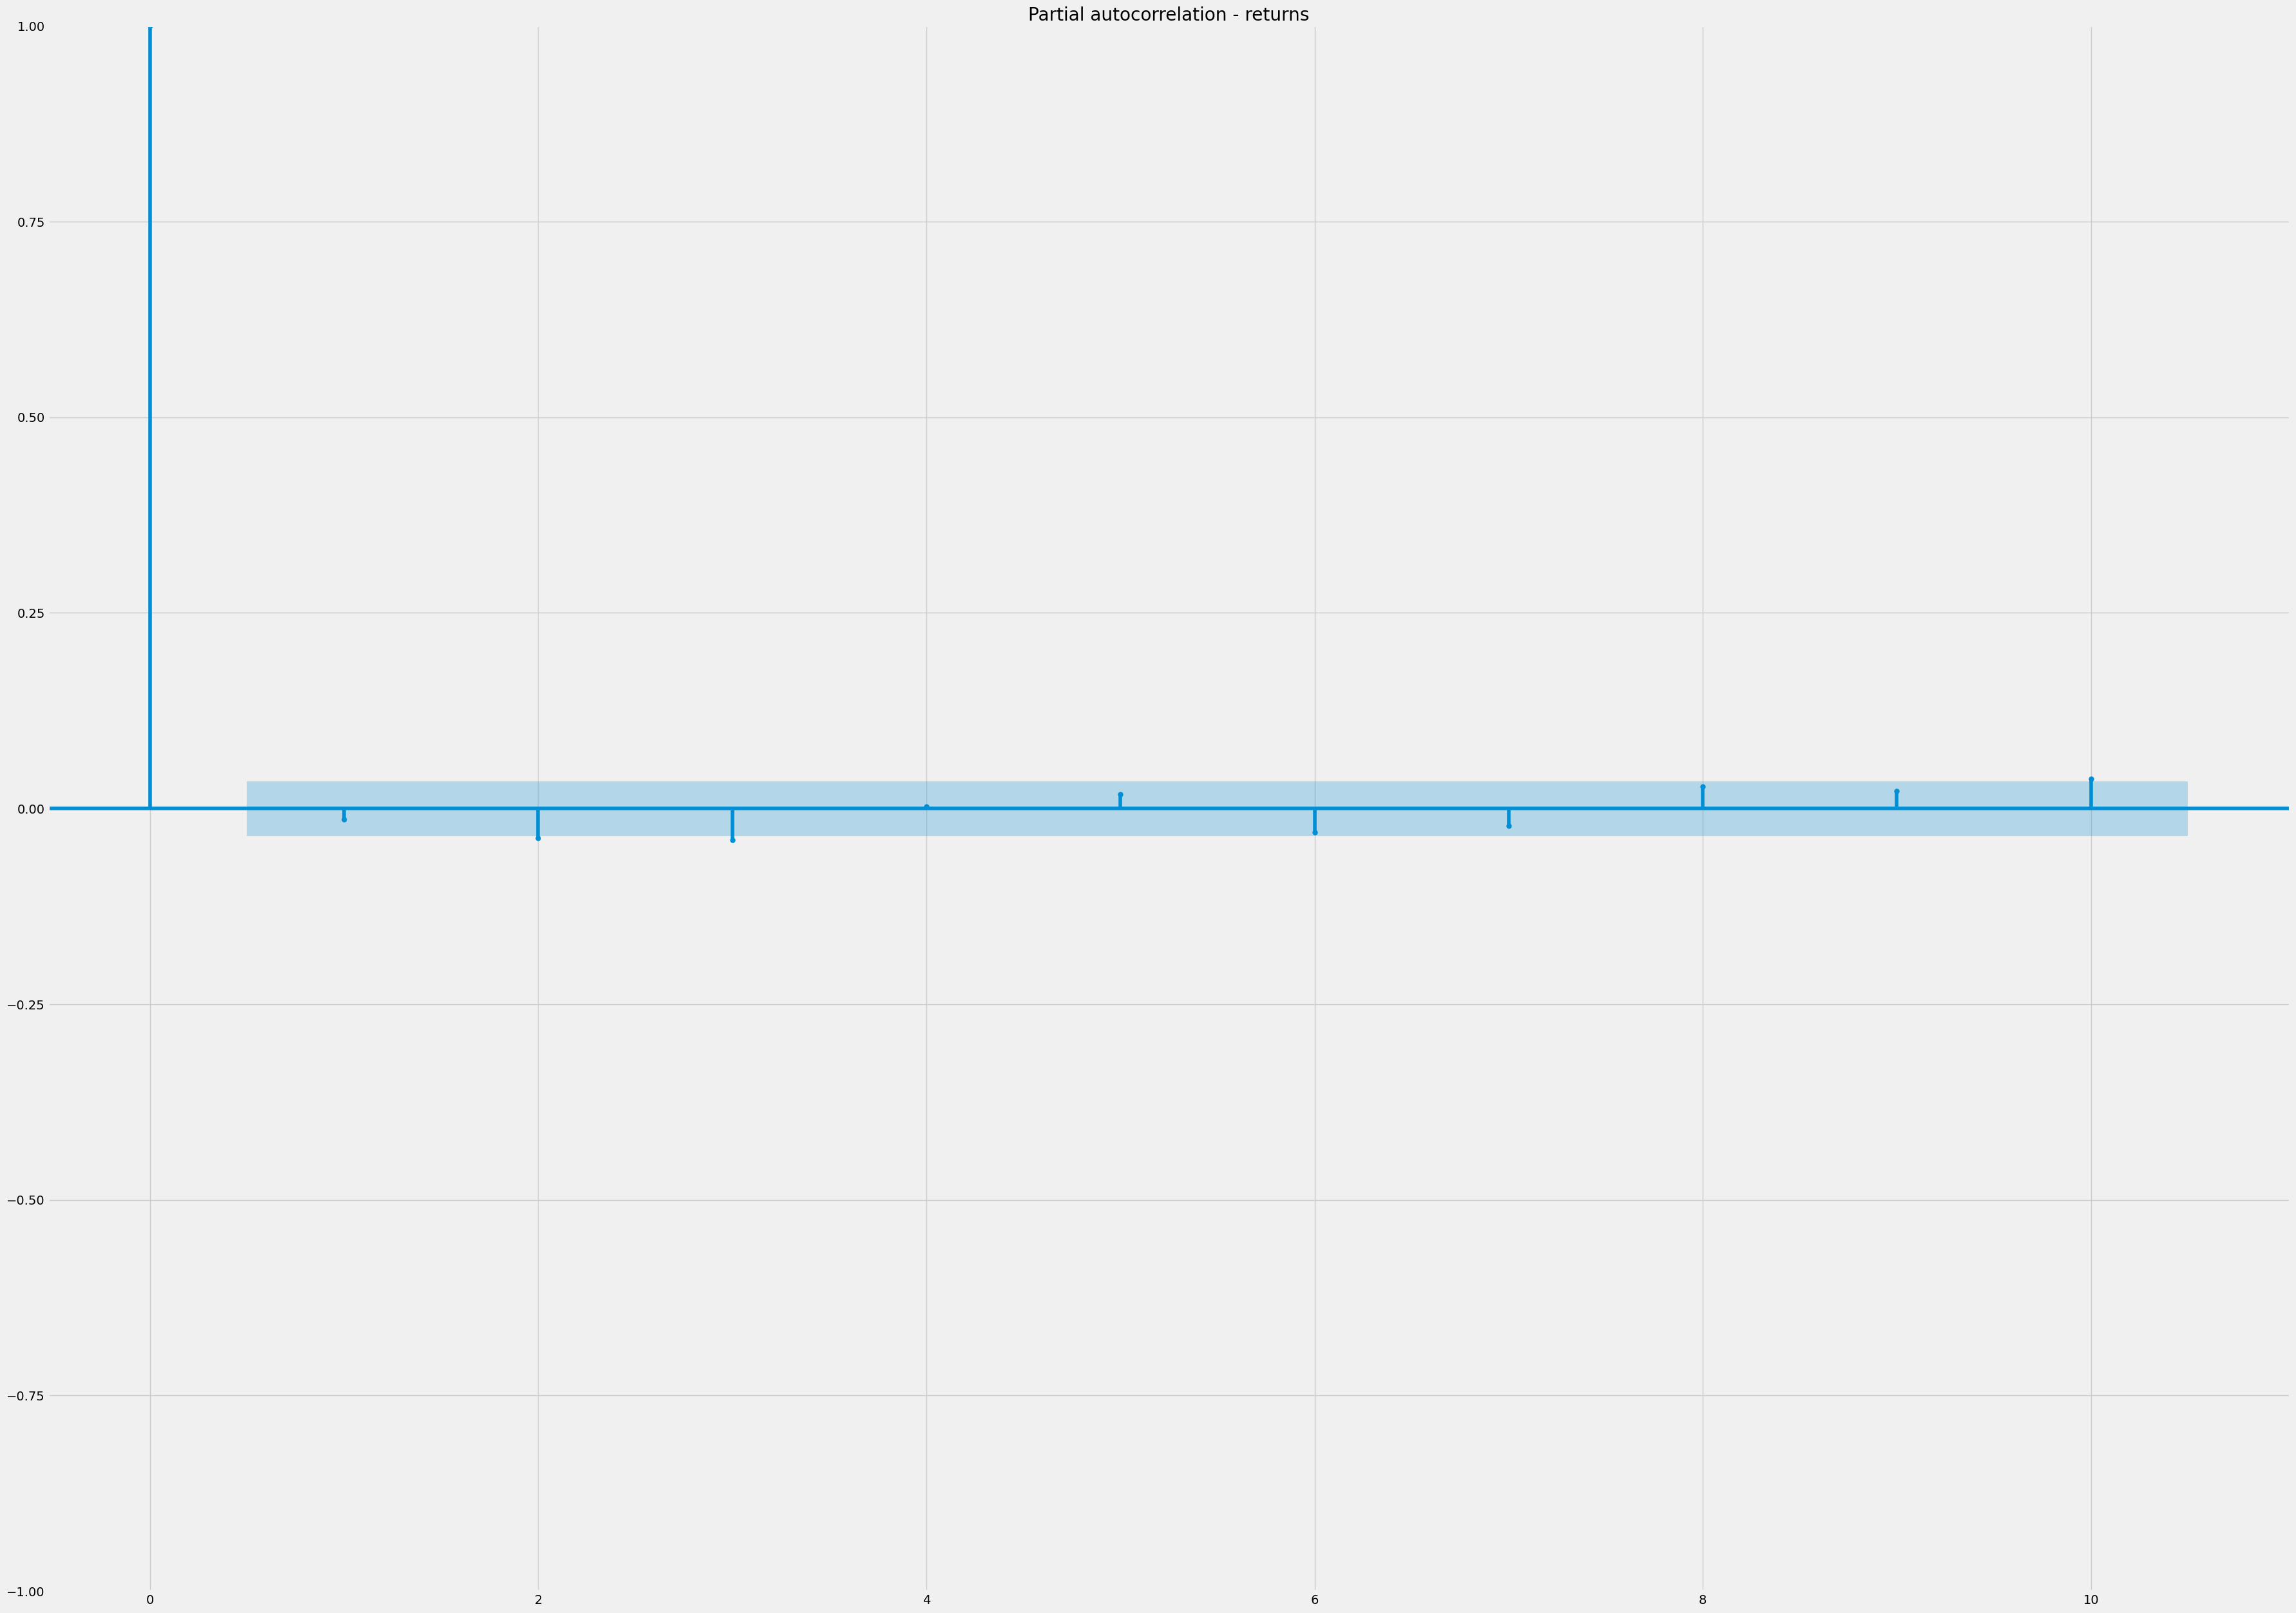

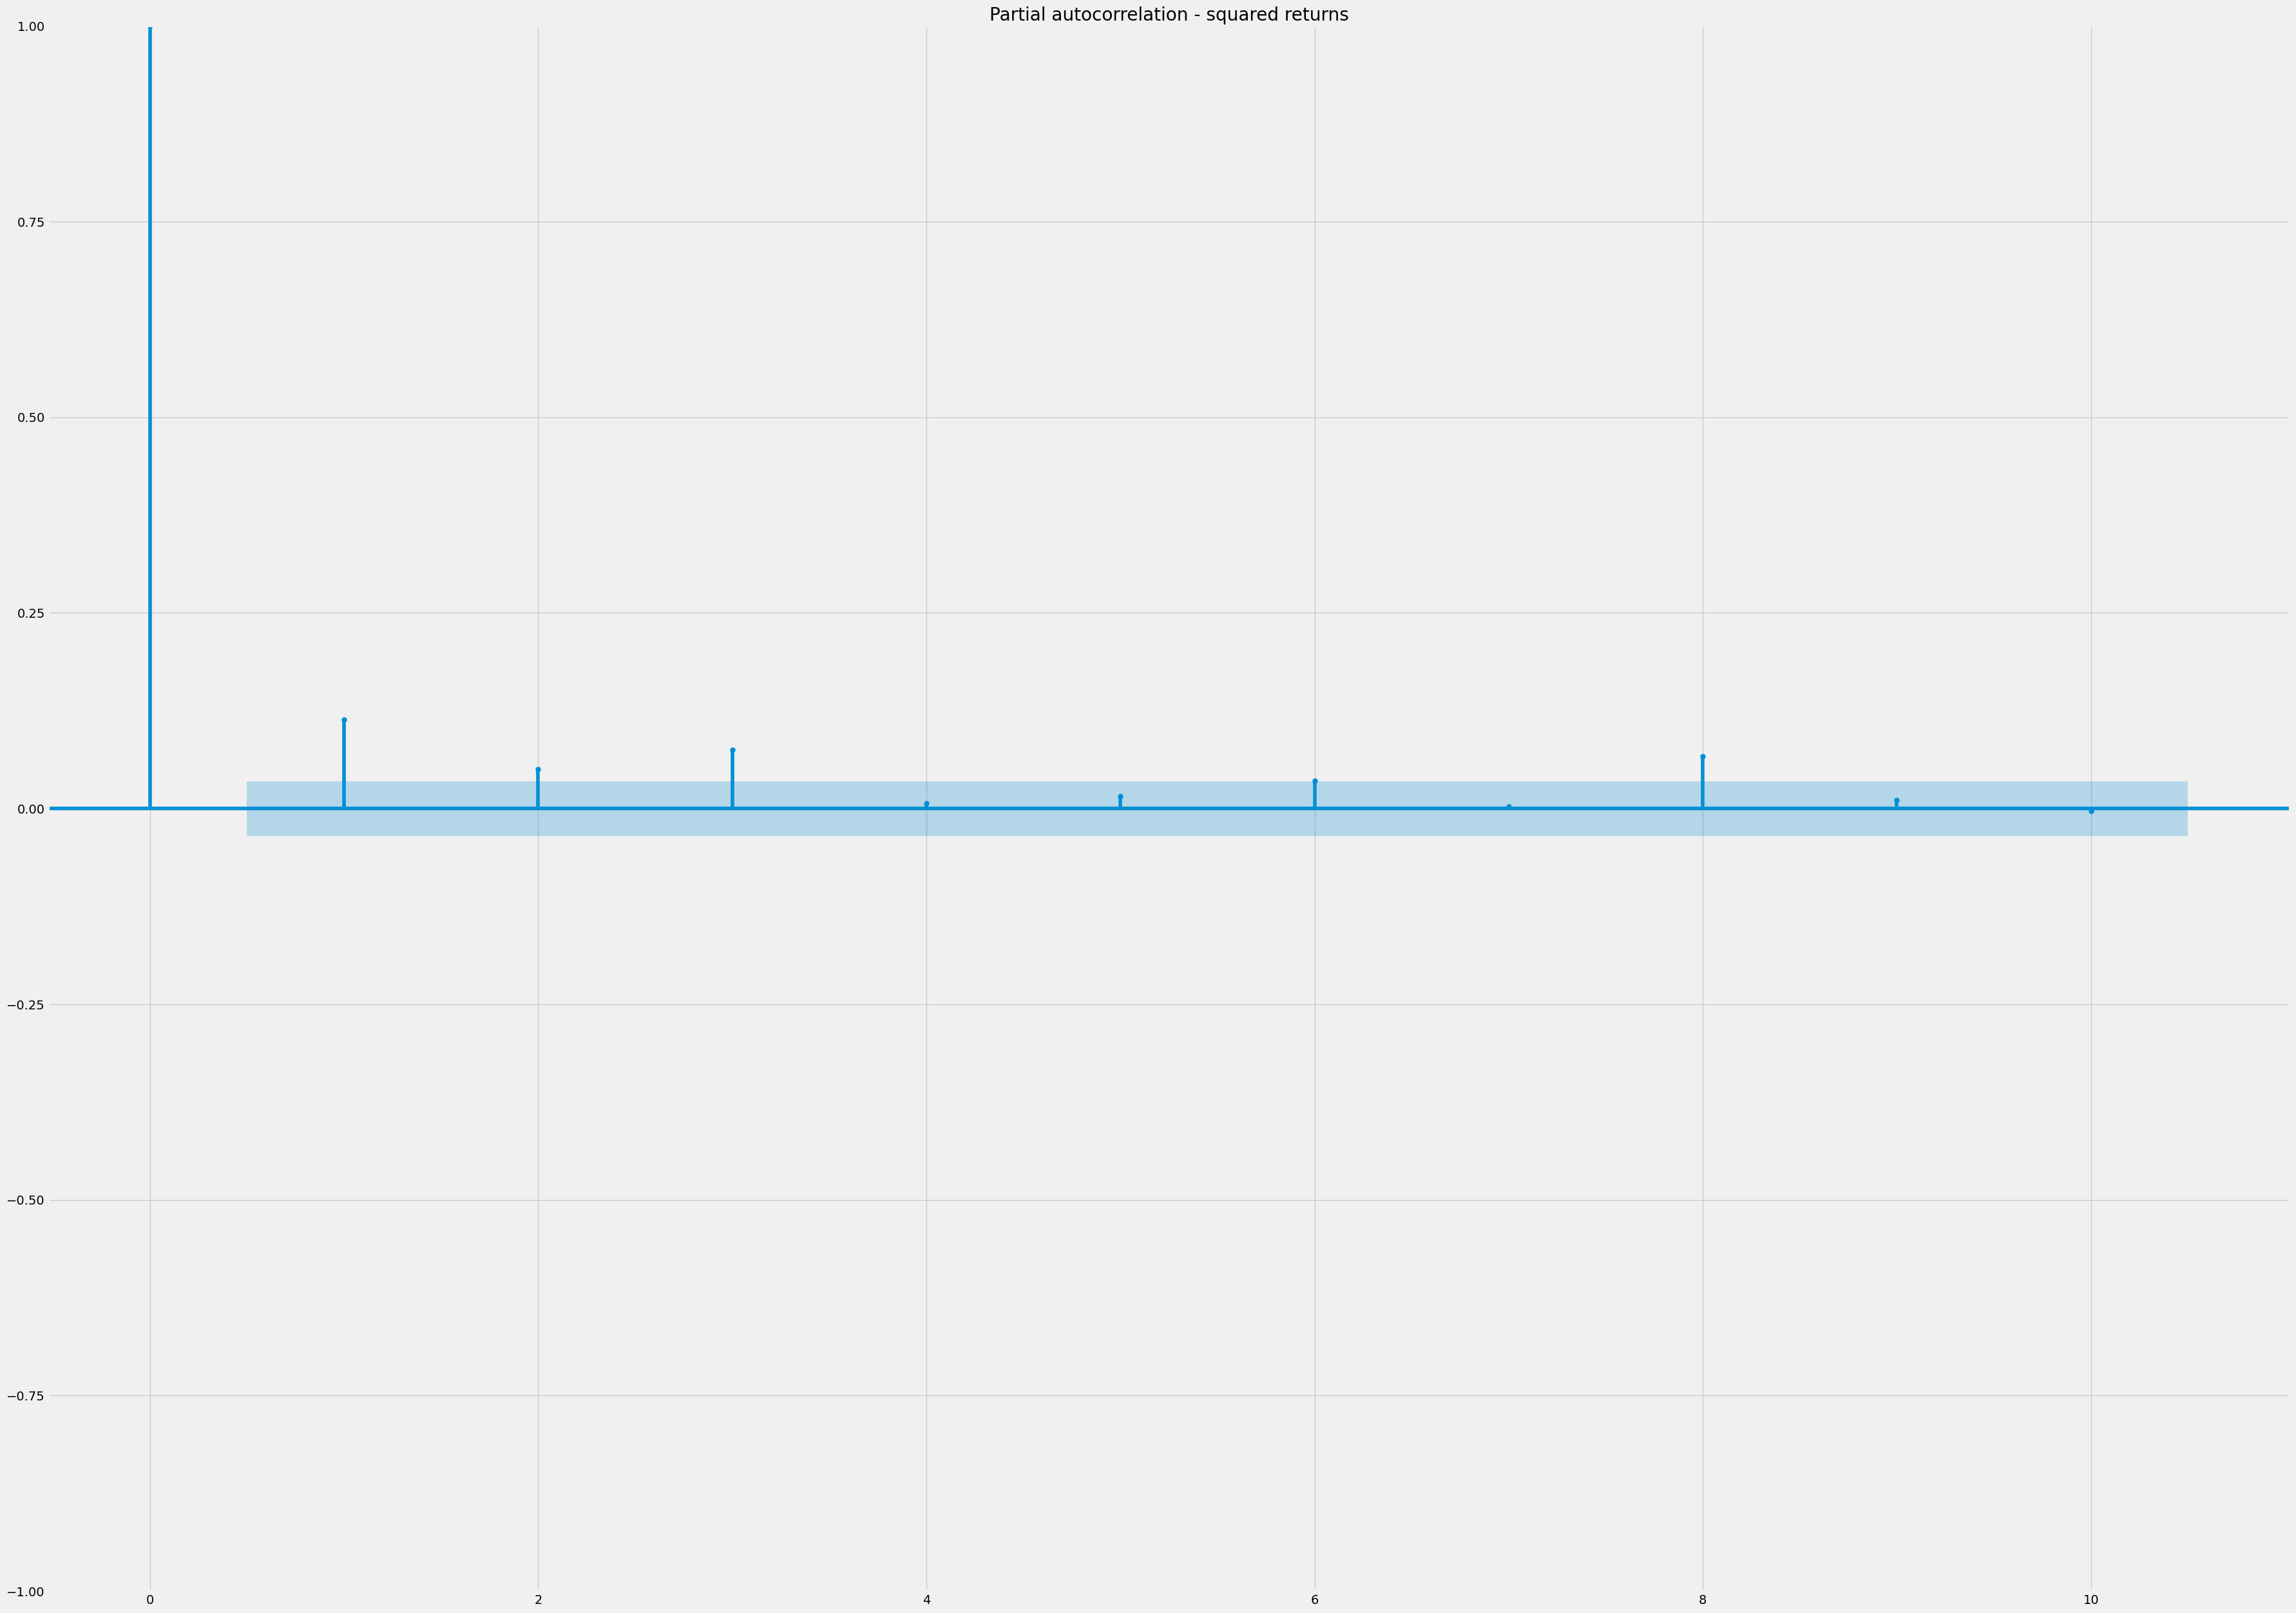

In [ ]:
plot_pacf(dfl, lags = 10, title='Partial autocorrelation - returns'); print()
plot_pacf(dfl**2, lags = 10, title='Partial autocorrelation - squared returns'); print()

In [ ]:
from arch import arch_model

am = arch_model(100 * dfl, p = 1, q = 0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     28,   Neg. LLF: 9490.985003842943
Iteration:     10,   Func. Count:     49,   Neg. LLF: 9417.8870796224
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9417.8870796224
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9417.89
Distribution:                  Normal   AIC:                           18841.8
Method:            Maximum Likelihood   BIC:                           18859.9
                                        No. Observations:                 3141
Date:                Thu, Apr 06 2023   Df Residuals:                     3140
Time:              

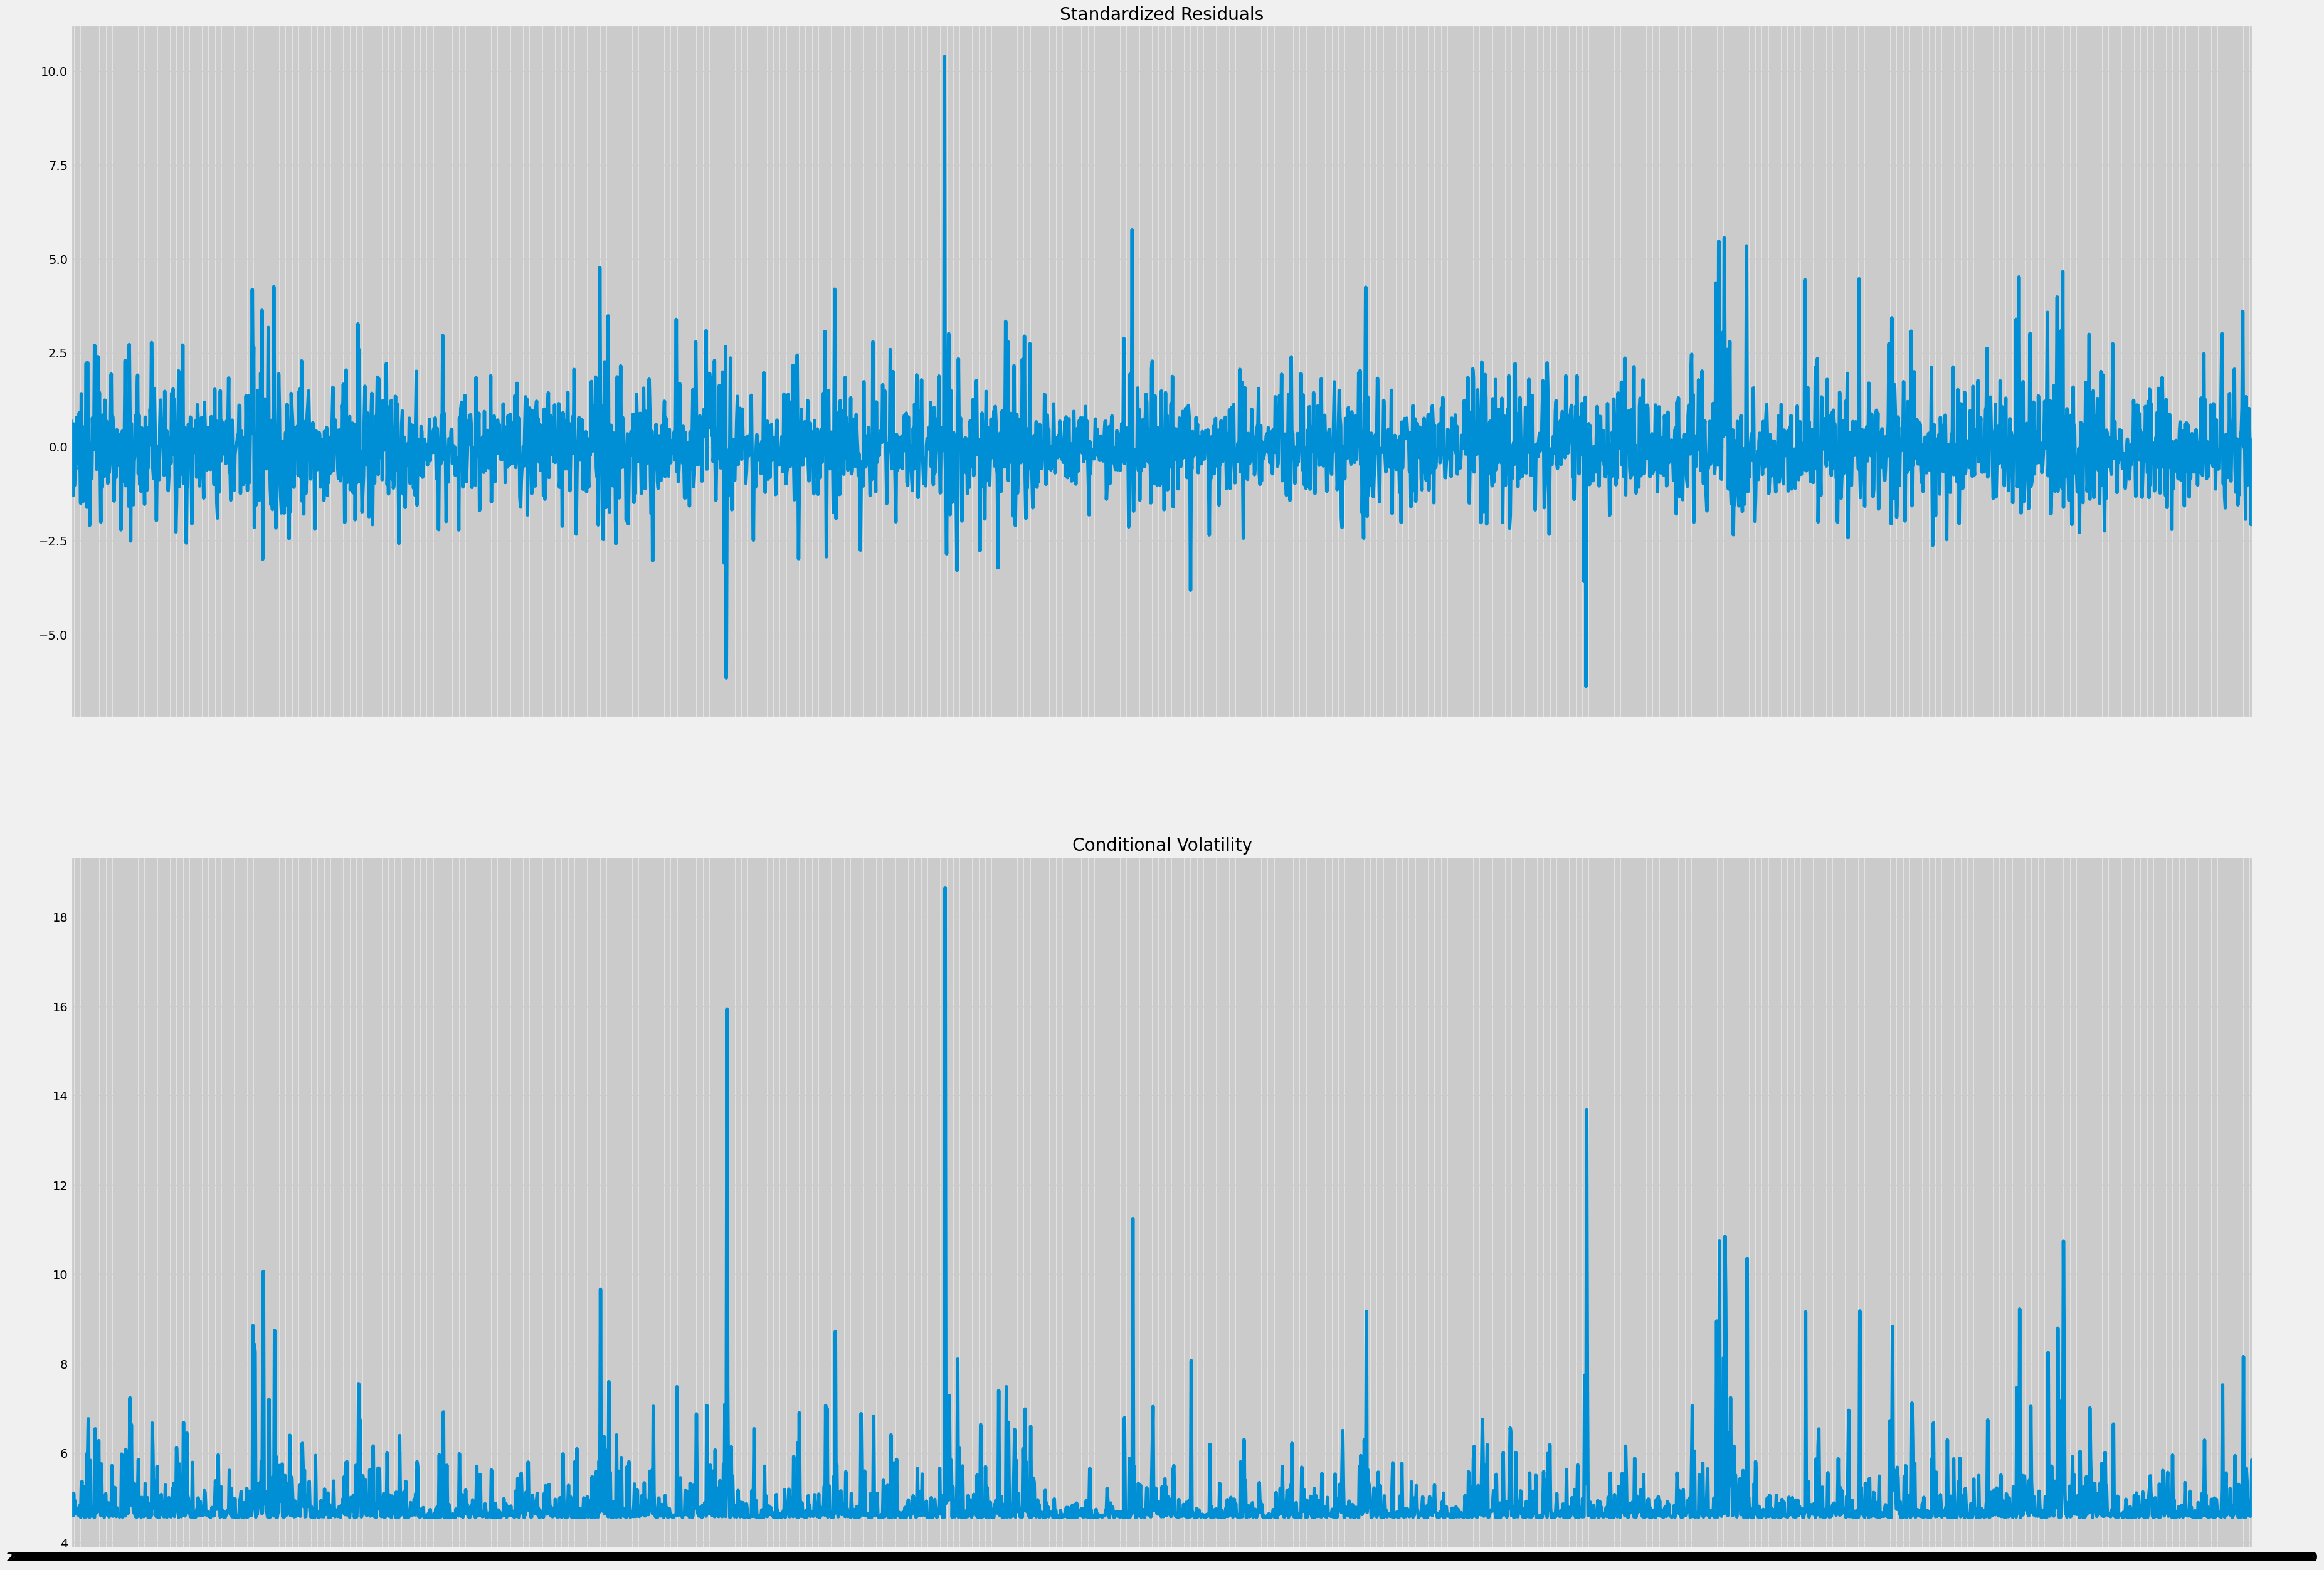

In [ ]:
res.plot(); print()

In [ ]:
max_lags = 5
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)

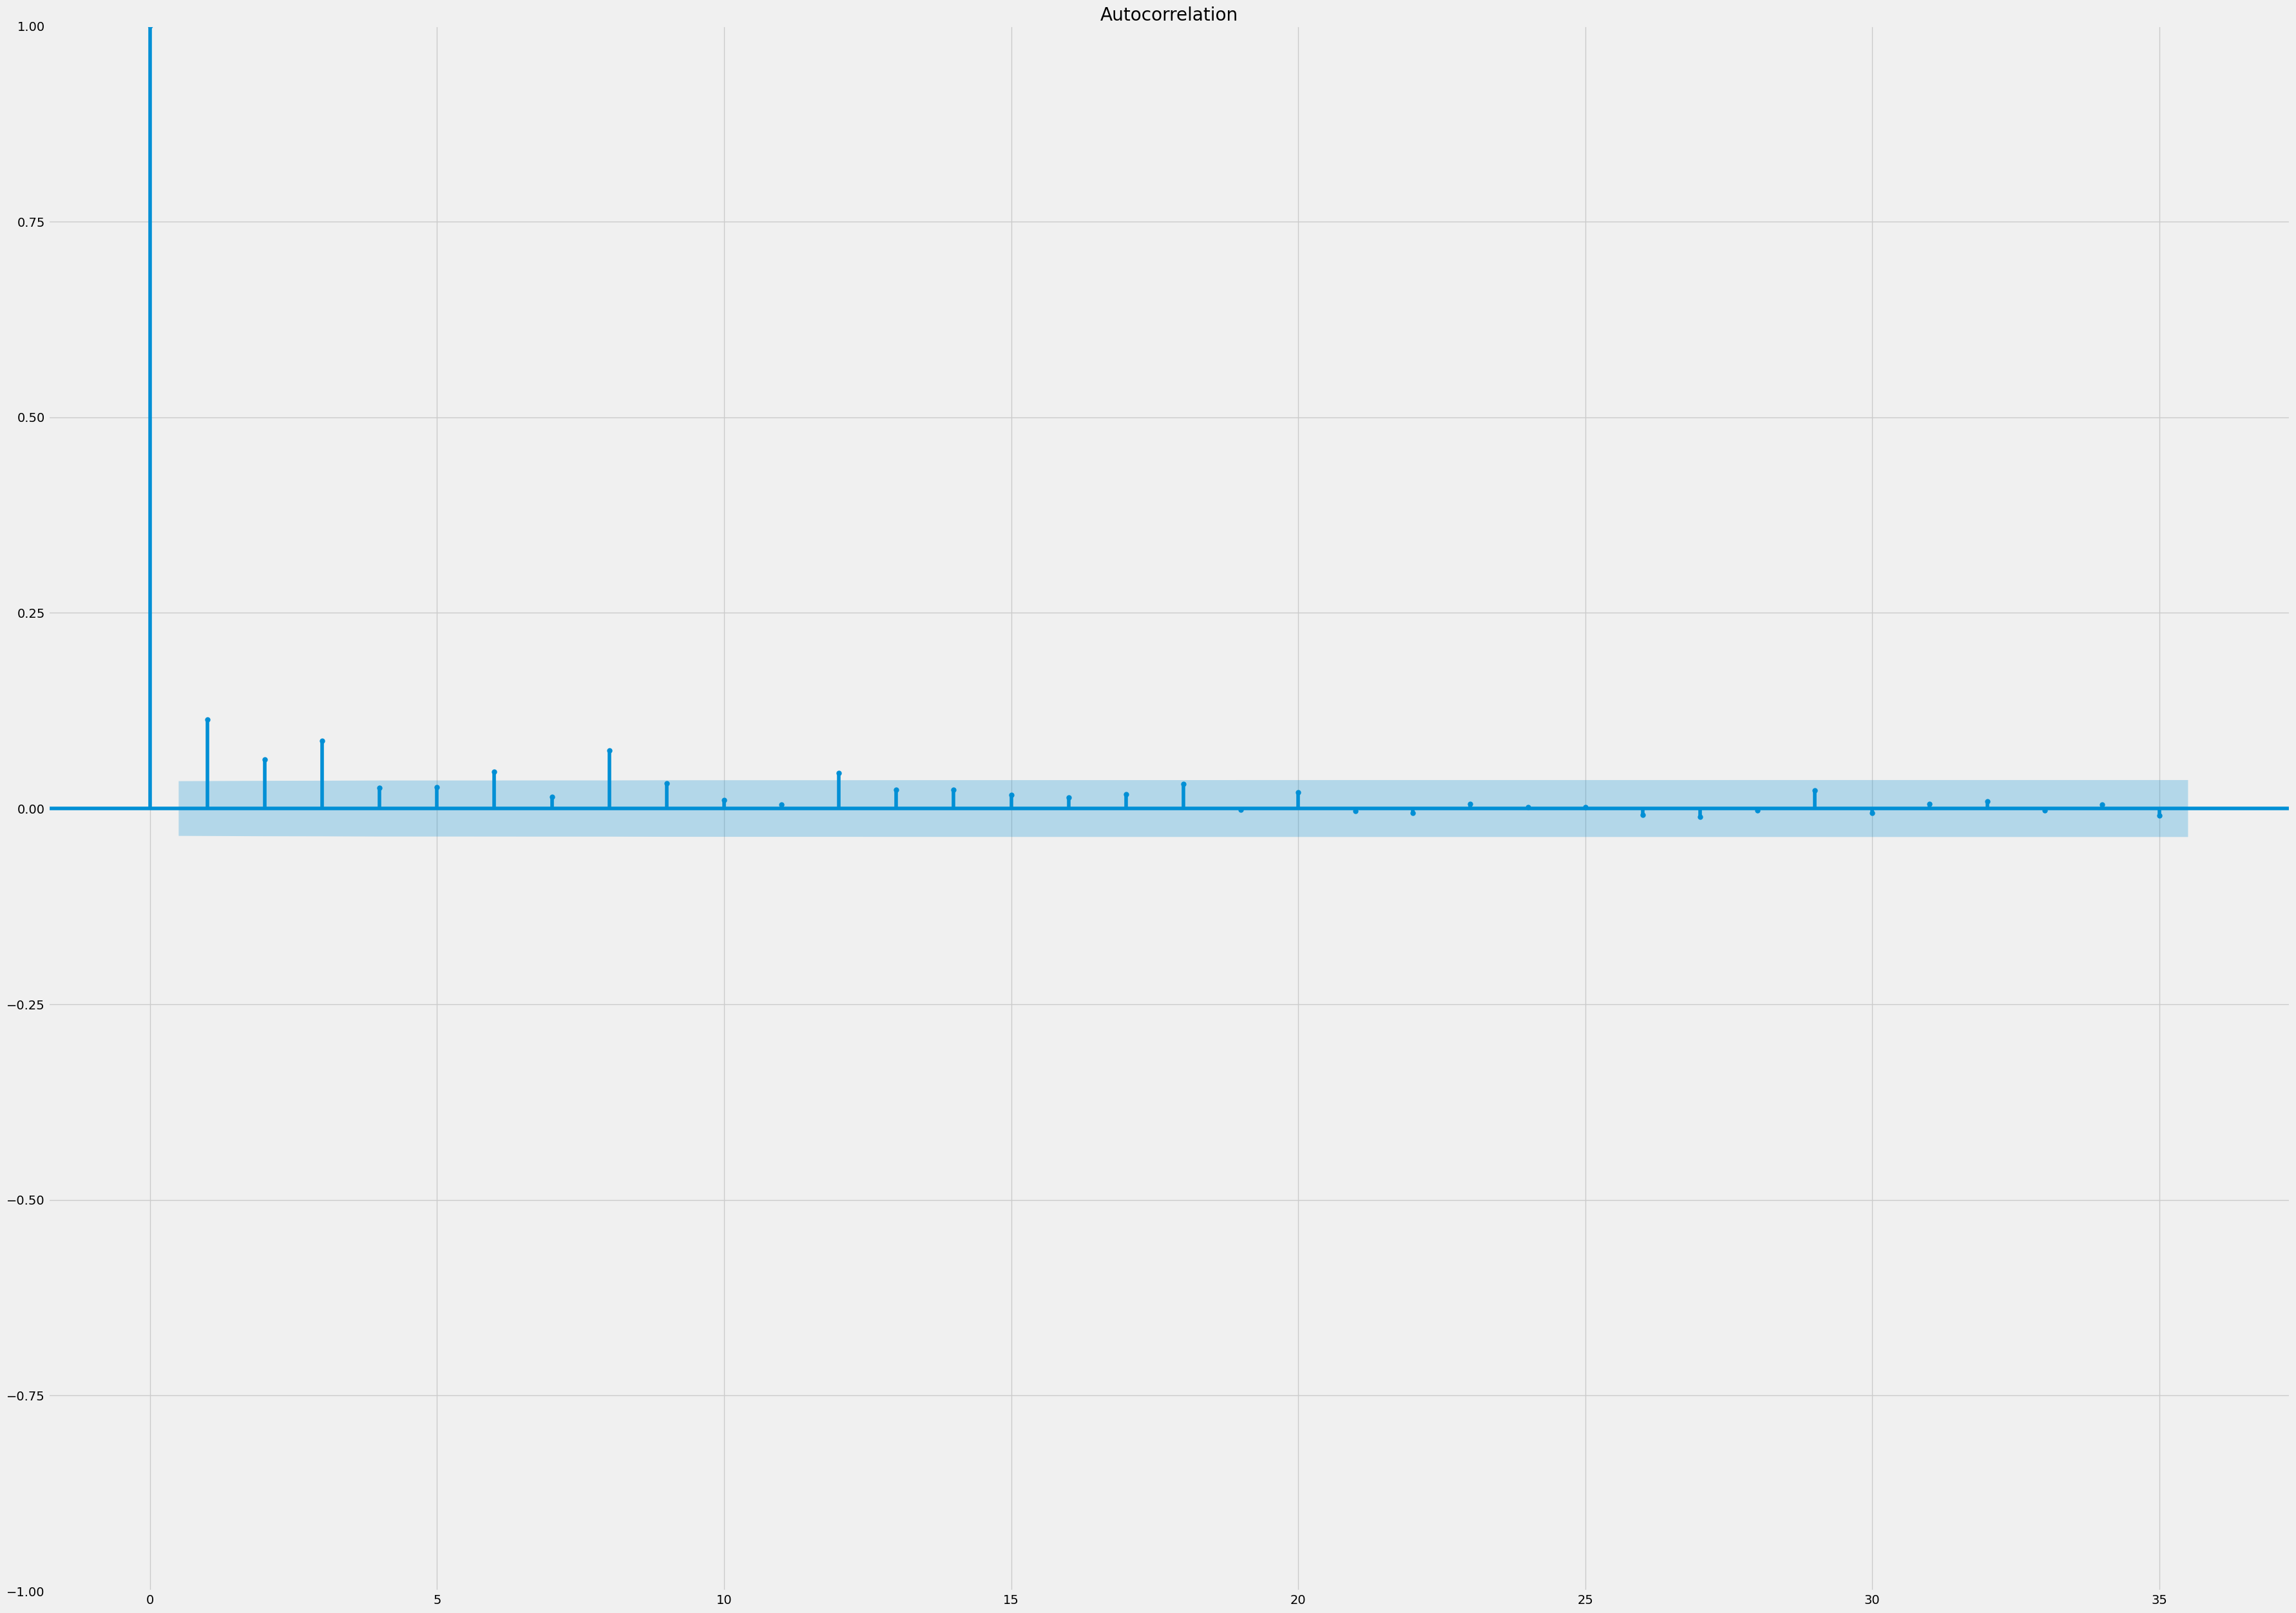

In [ ]:
plot_acf(dfl ** 2); print()

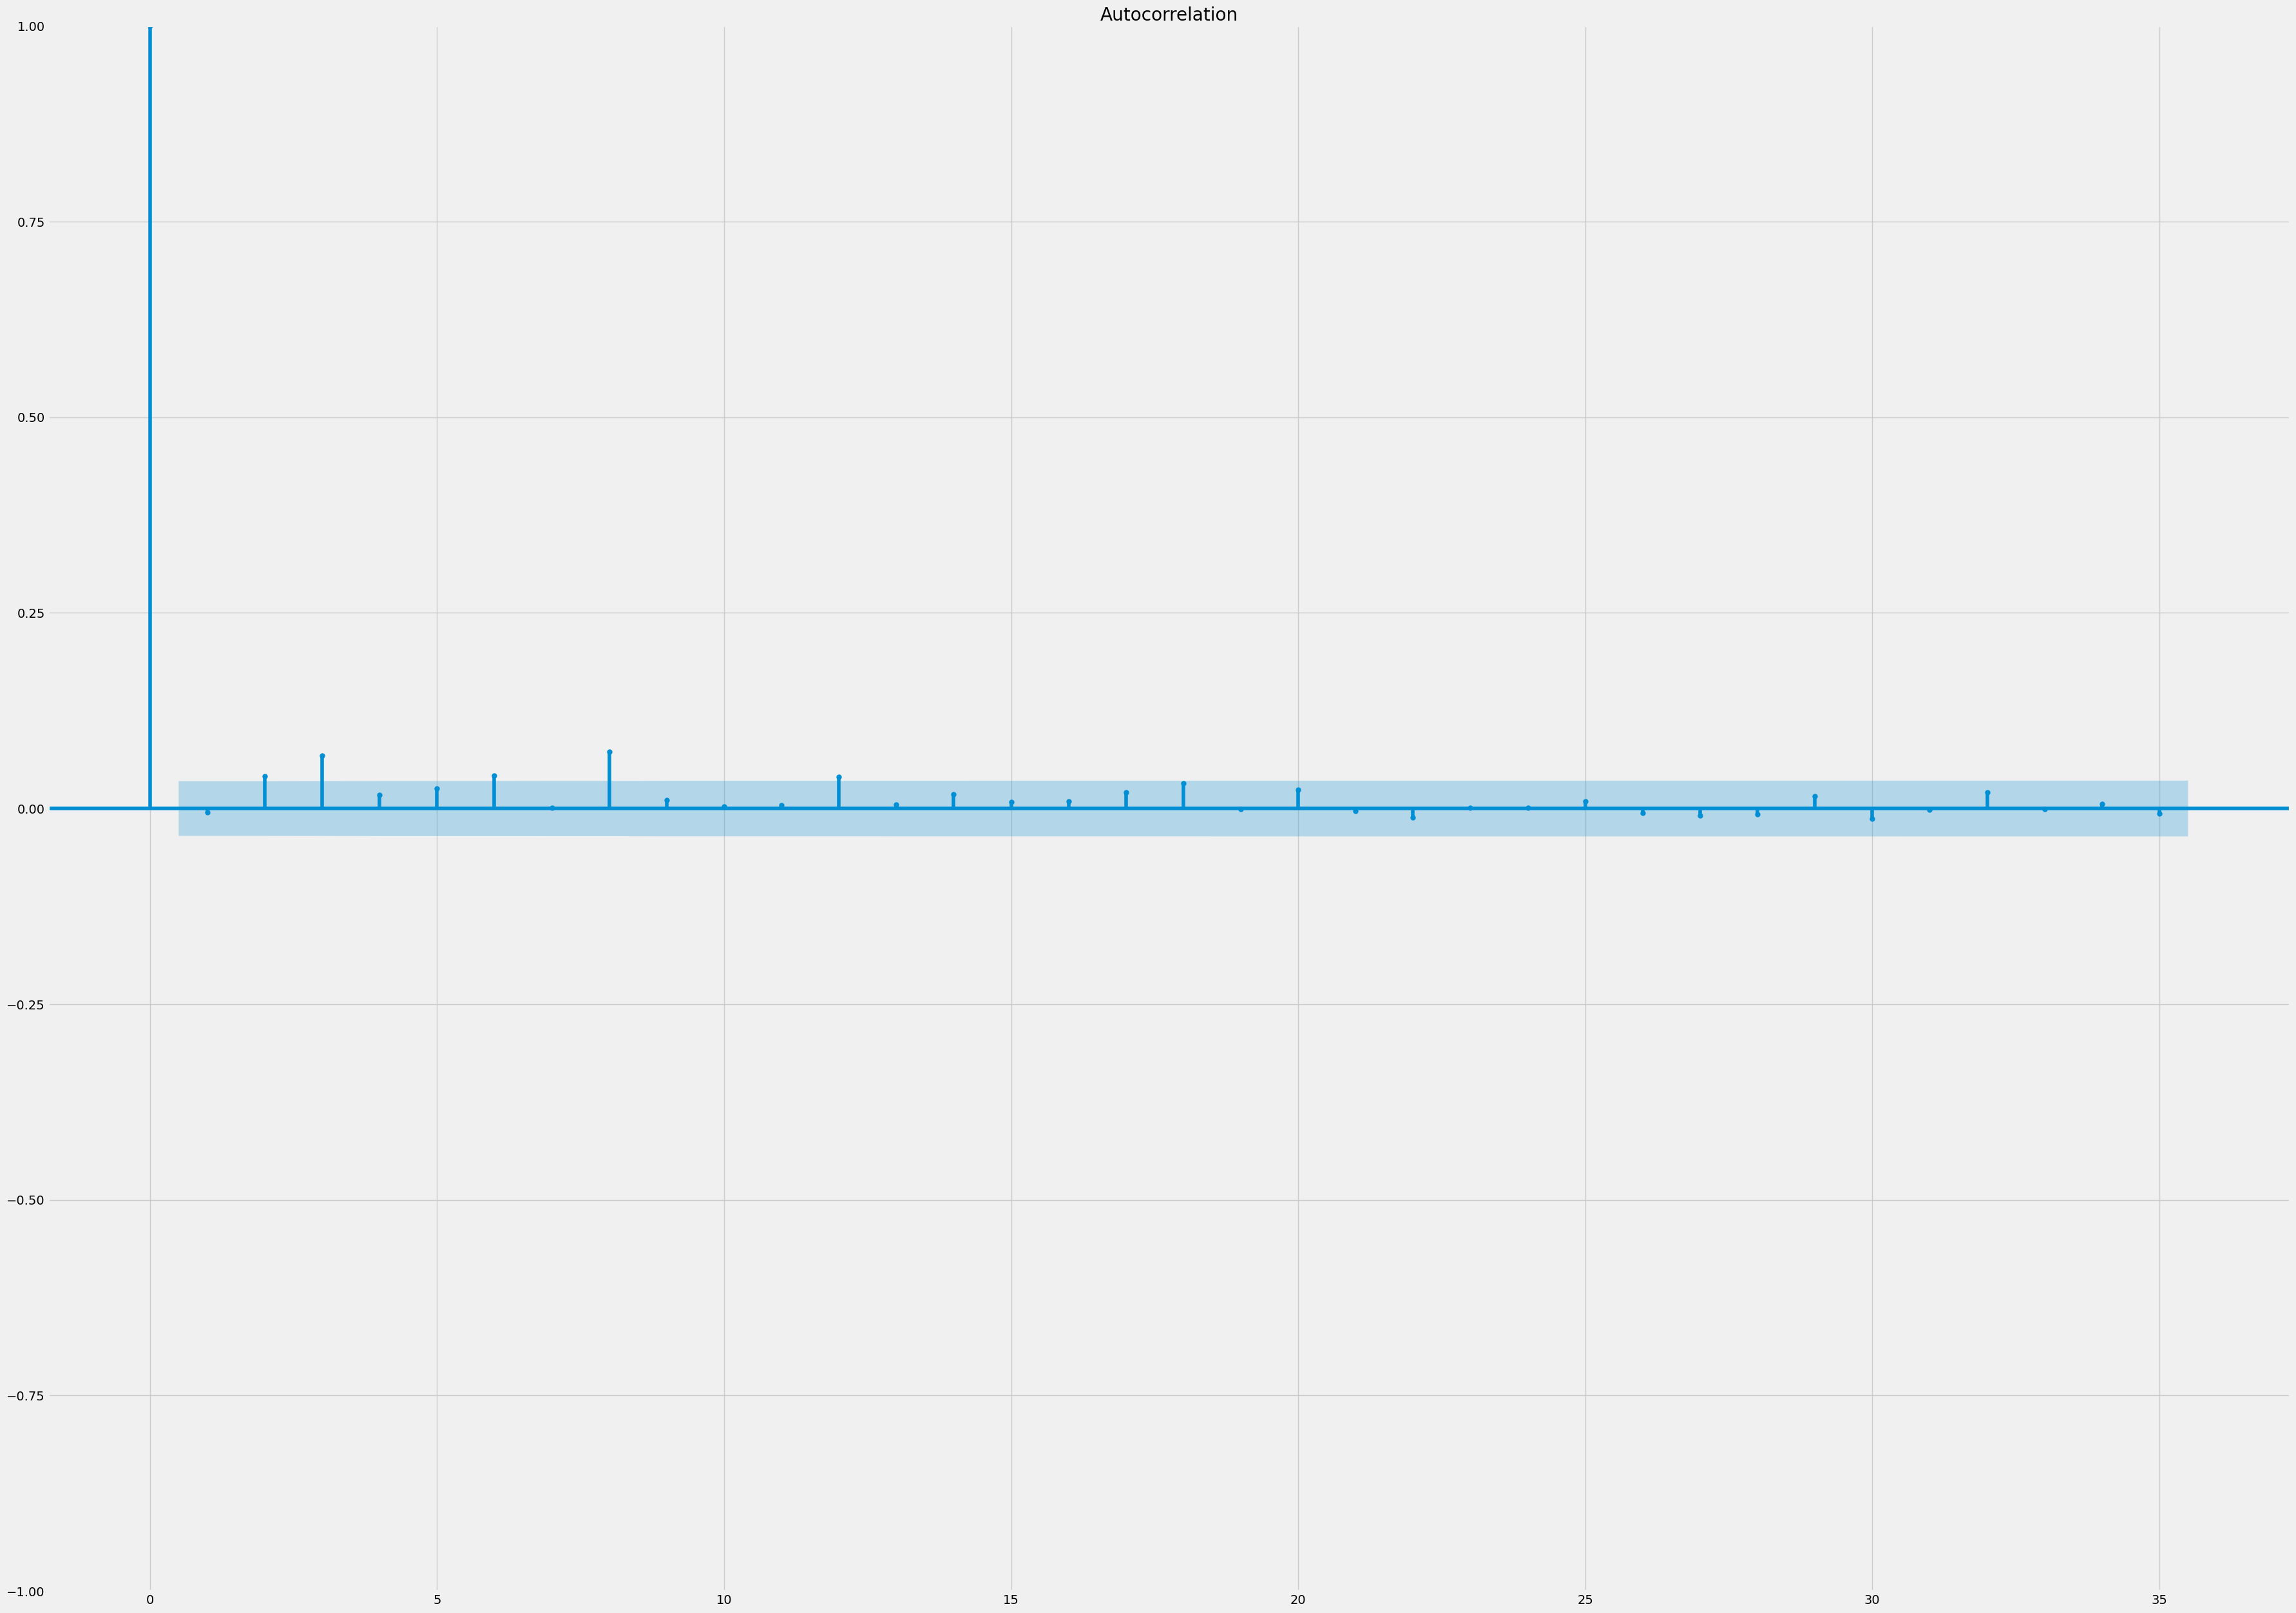

In [ ]:
plot_acf(st_residuals ** 2); print()

In [ ]:
lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)

In [ ]:
np.round(lb_test["lb_pvalue"],4)

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: lb_pvalue, dtype: float64

In [ ]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)

In [ ]:
np.round(lb_test["lb_pvalue"],4)

1    0.7913
2    0.0651
3    0.0002
4    0.0003
5    0.0003
Name: lb_pvalue, dtype: float64

In [ ]:
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [ ]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0005
pval F-test: 0.0005


In [ ]:
gm = arch_model(100 * dfl, p = 1, q = 1)
res = gm.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 9399.274960242923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9362.433649848163
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9362.43
Distribution:                  Normal   AIC:                           18732.9
Method:            Maximum Likelihood   BIC:                           18757.1
                                        No. Observations:                 3141
Date:                Thu, Apr 06 2023   Df Residuals:                     3140
Time:                        19:35:57   Df Model:                            1
          

In [ ]:
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)
lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)


In [ ]:
np.round(lb_test.lb_pvalue,4)

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: lb_pvalue, dtype: float64

In [ ]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)

In [ ]:
np.round(lb_test.lb_pvalue,4)

1    0.7617
2    0.9445
3    0.9277
4    0.9759
5    0.9930
Name: lb_pvalue, dtype: float64

In [ ]:
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [ ]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.9932
pval F-test: 0.9932


In [ ]:
from arch.univariate import ARX

ar = ARX(100 * dfl, lags=[1, 3])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                  close   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:          Constant Variance   Log-Likelihood:               -9458.78
Distribution:                  Normal   AIC:                           18925.6
Method:            Maximum Likelihood   BIC:                           18949.8
                                        No. Observations:                 3138
Date:                Thu, Apr 06 2023   Df Residuals:                     3135
Time:                        19:38:11   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const         -0.0134  8.807e-02     -0.152      0.879 

In [ ]:
from arch.univariate import ARCH, GARCH

ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  close   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -9351.72
Distribution:                  Normal   AIC:                           18715.4
Method:            Maximum Likelihood   BIC:                           18751.7
                                        No. Observations:                 3138
Date:                Thu, Apr 06 2023   Df Residuals:                     3135
Time:                        19:39:18   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -8.9935e-03  8.180e-02     -0.110      0.

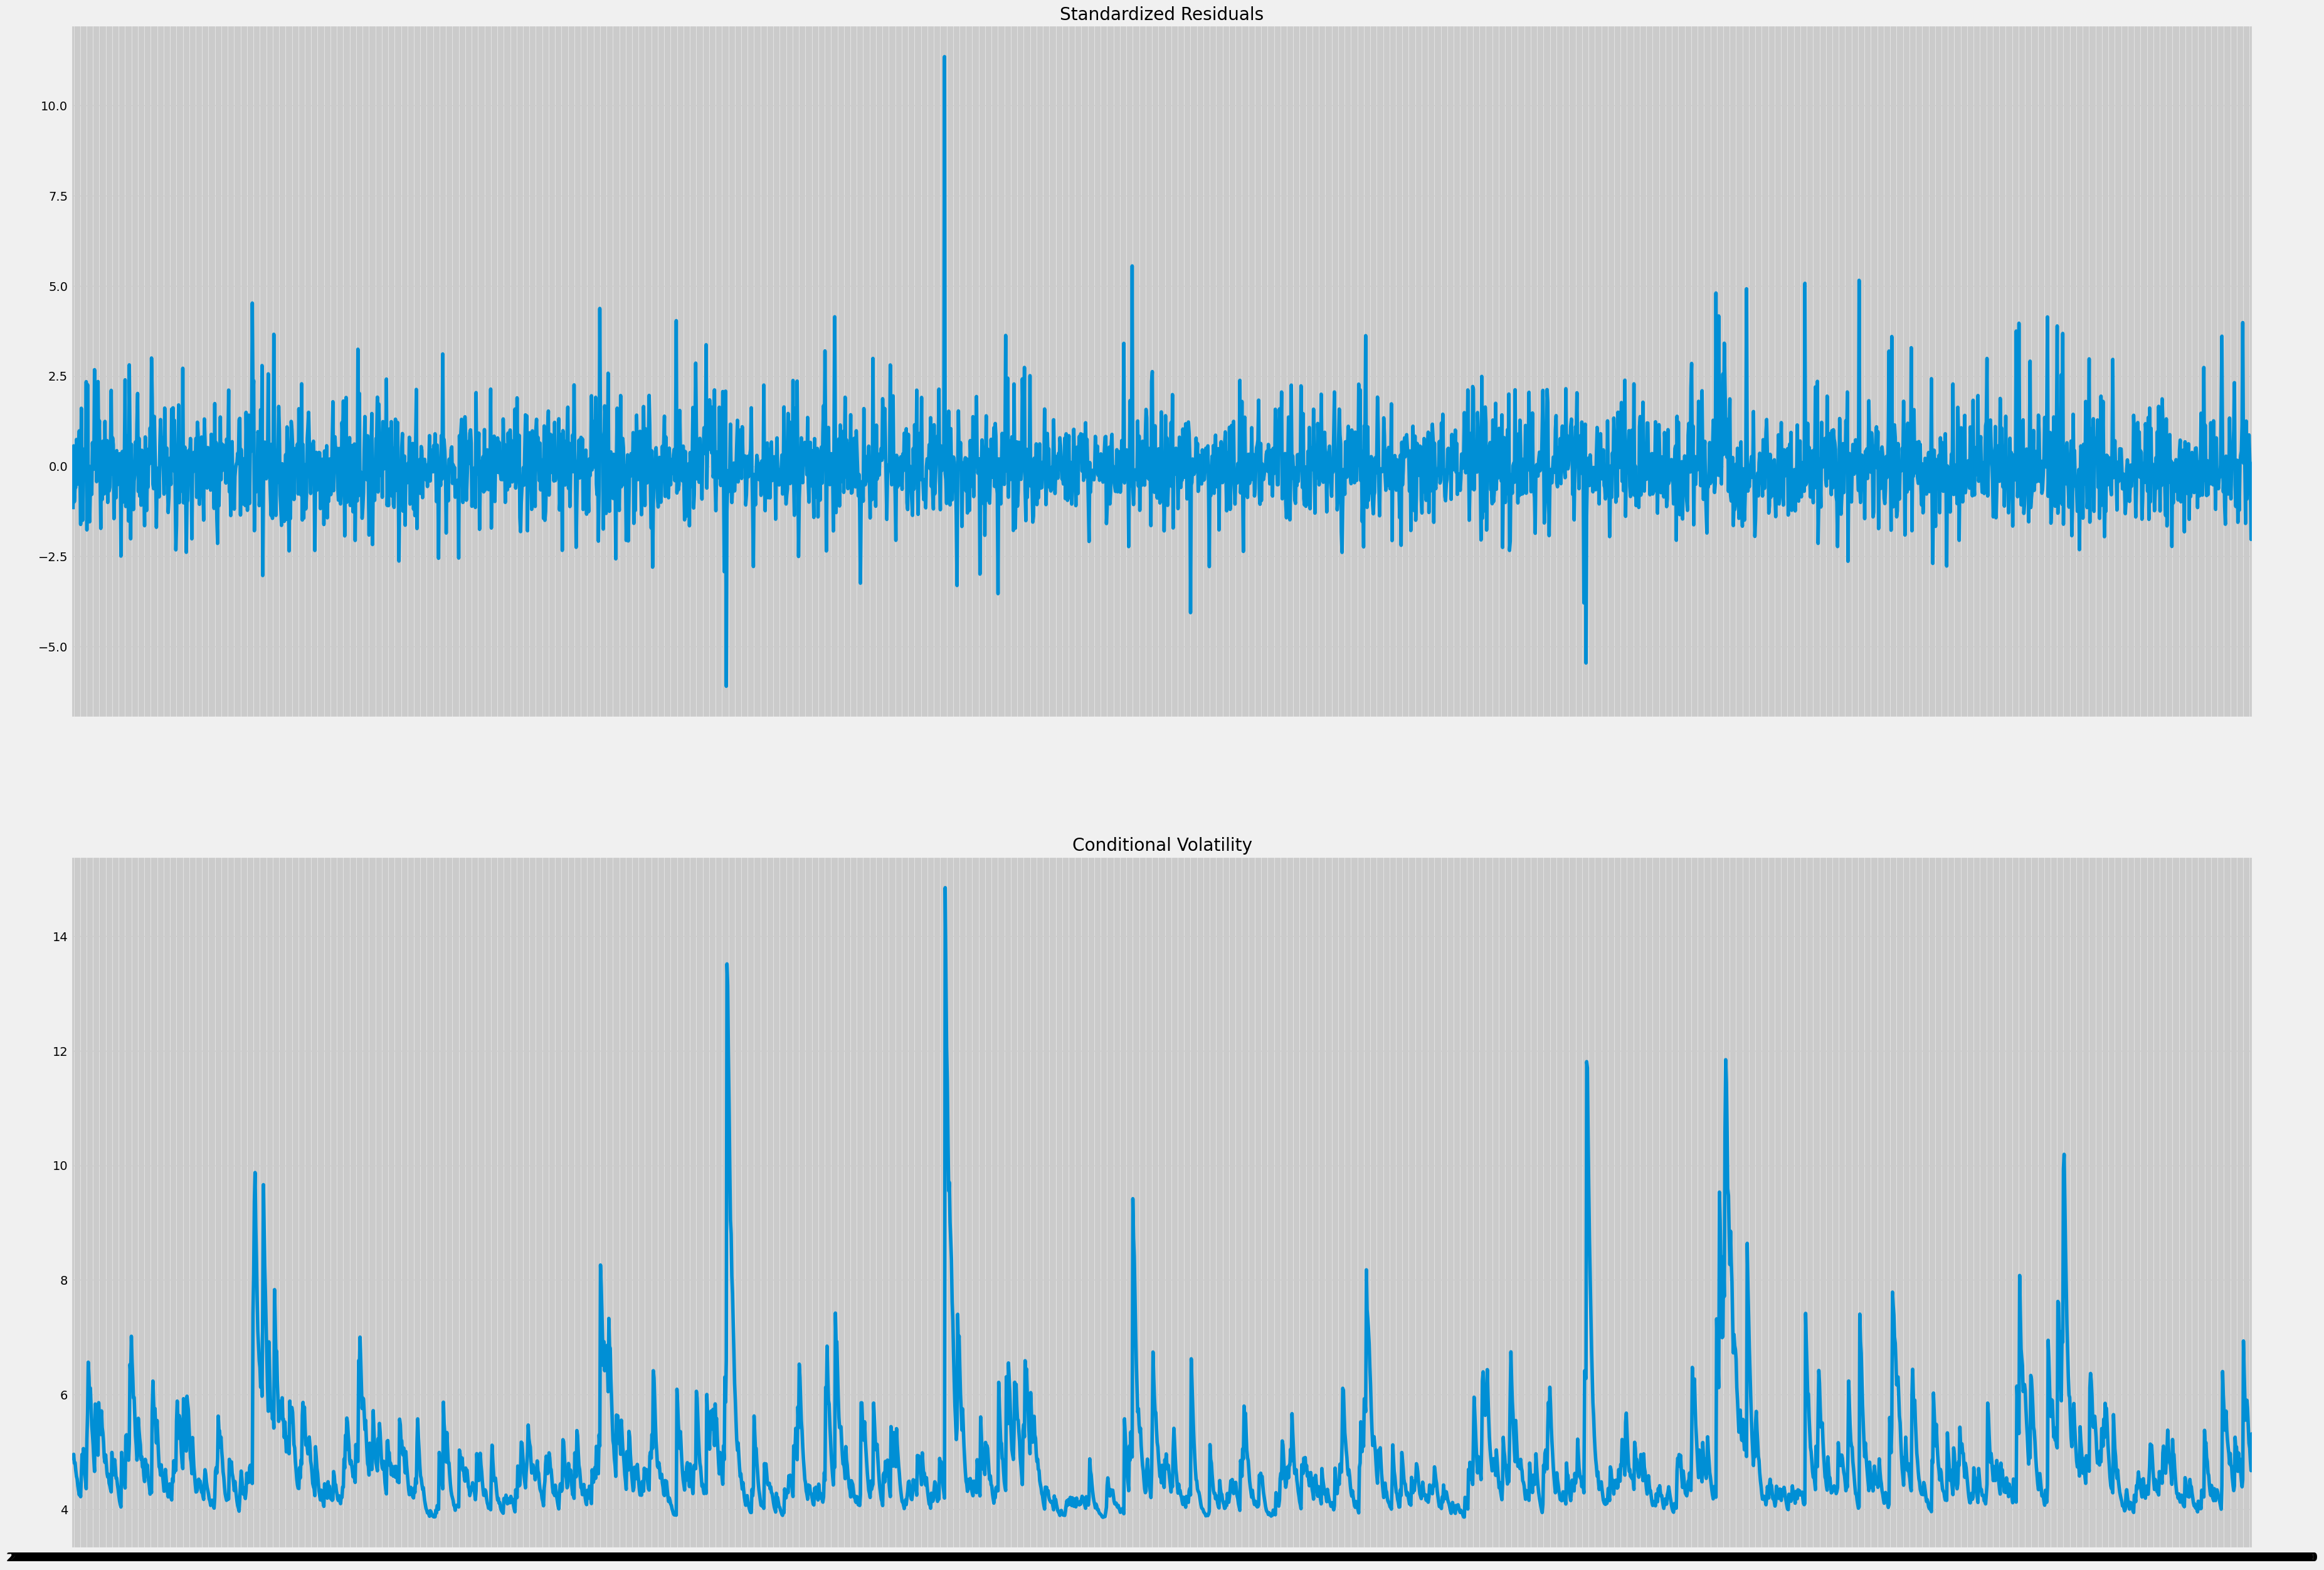

In [ ]:
fig = res.plot()

In [ ]:
import pandas as pd
from arch import arch_model


gjr_garch = arch_model(data.close, p=1, o=1, q=1, vol='Garch', dist='Normal')
gjr_garch_fit = gjr_garch.fit()

print(gjr_garch_fit.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 43607.90089262734
Iteration:      2,   Func. Count:     17,   Neg. LLF: 125080271.26455277
Iteration:      3,   Func. Count:     24,   Neg. LLF: 11911.335121950724
Iteration:      4,   Func. Count:     31,   Neg. LLF: 16336117.858067185
Iteration:      5,   Func. Count:     38,   Neg. LLF: 454398840.0477221
Iteration:      6,   Func. Count:     45,   Neg. LLF: 58073.50382208811
Iteration:      7,   Func. Count:     52,   Neg. LLF: 18464.143361017424
Iteration:      8,   Func. Count:     59,   Neg. LLF: 8120.347697006243
Iteration:      9,   Func. Count:     66,   Neg. LLF: 7755.001065882127
Iteration:     10,   Func. Count:     72,   Neg. LLF: 7771.446833605103
Iteration:     11,   Func. Count:     79,   Neg. LLF: 7747.478121828013
Iteration:     12,   Func. Count:     86,   Neg. LLF: 7738.676818968812
Iteration:     13,   Func. Count:     92,   Neg. LLF: 7738.799826408142
Iteration:     14,   Func. Count:     99,   Neg. LLF: 7736.9

In [ ]:
dfl = np.log1p(data.close).diff().dropna()
print(data.index.min(), data.index.max())

2010-07-23 03:45:00 2023-04-05 03:45:00


In [ ]:
xtr, xval = dfl.loc[:'2023-01-01'], dfl.loc['2023-01-01':]

In [ ]:
ar = ARX(100 * xtr, lags=[1])
ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                  close   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -9162.01
Distribution:                  Normal   AIC:                           18334.0
Method:            Maximum Likelihood   BIC:                           18364.2
                                        No. Observations:                 3076
Date:                Thu, Apr 06 2023   Df Residuals:                     3074
Time:                        19:53:52   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -2.1137e-03  8.243e-02 -2.564e-02      0.

In [ ]:
xfor = res.forecast(horizon= xval.shape[0])

# ugly workaround, I know
mean_forecast = xfor.mean.tail(1).values.reshape(len(xval),1)

forecast = pd.DataFrame()
forecast['Date'] = xval.index
forecast['close'] = xval.values
forecast['fc_mean'] = xfor.mean.tail(1).values.reshape(len(xval),1)
forecast['fc_std'] = np.sqrt(xfor.variance.tail(1).values.reshape(len(xval),1))

In [ ]:
forecast

,Date,close,fc_mean,fc_std
0,2023-01-02 03:45:00,-0.011568,-0.014625,4.400338
1,2023-01-03 03:45:00,-0.019312,-0.001587,4.472213
2,2023-01-04 03:45:00,0.051464,-0.002056,4.532154
3,2023-01-05 03:45:00,-0.013363,-0.002040,4.584236
4,2023-01-06 03:45:00,0.002656,-0.002040,4.629570
...,...,...,...,...
59,2023-03-28 03:45:00,-0.021202,-0.002040,4.948333
60,2023-03-29 03:45:00,-0.095916,-0.002040,4.948365
61,2023-03-31 03:45:00,-0.048500,-0.002040,4.948394
62,2023-04-03 03:45:00,-0.025437,-0.002040,4.948419


In [ ]:

market = data["close"]
returns = 100 * market.pct_change().dropna()

In [ ]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

In [ ]:
forecasts = res.forecast(start="2018-1-1", reindex=False)
cond_mean = forecasts.mean["2018":]
cond_var = forecasts.variance["2018":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.31953269 -1.40224524]


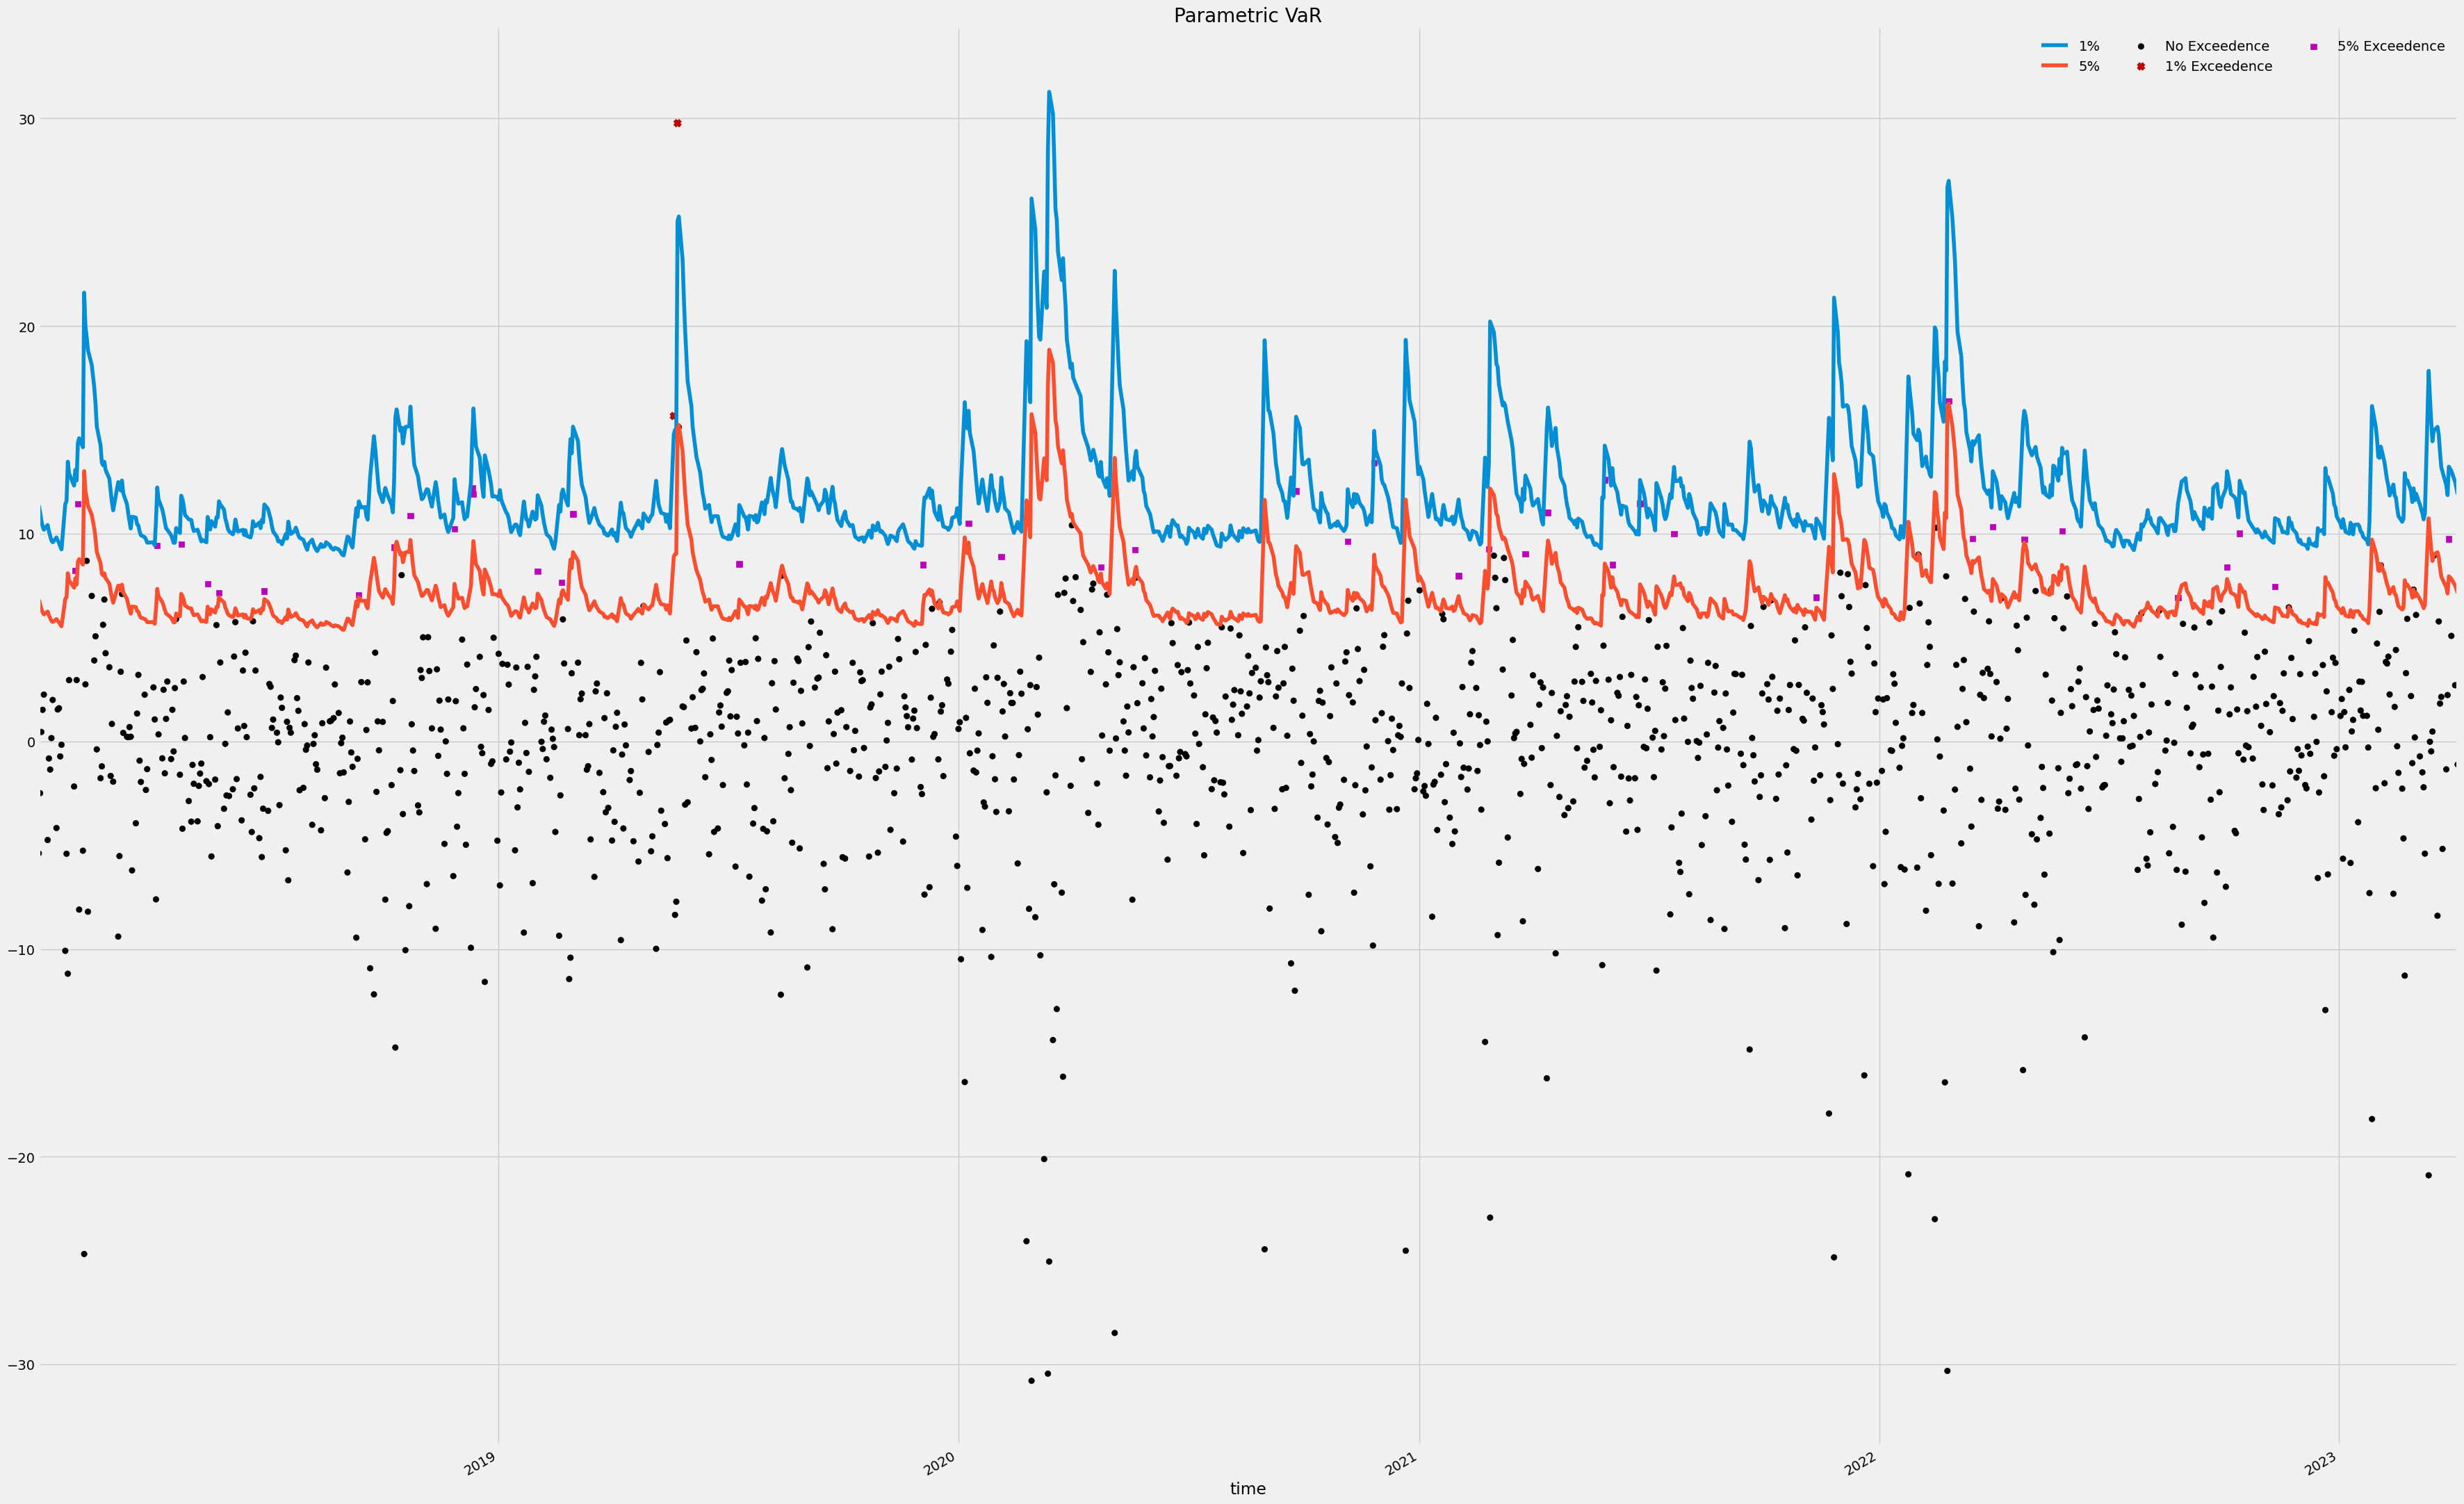

In [ ]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {"#BB0000": "1% Exceedence", "#BB00BB": "5% Exceedence", "#000000": "No Exceedence",}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)